Import Libraries

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

import matplotlib.pyplot as plt
import os

# set up initial path to data
DATADIR = os.path.join("sample-data","data")
game_id = 2 # let's look at sample match 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import Metrics

In [4]:
import Metrica_IO as mio
import Metrica_Viz as mviz

In [5]:
# read in the event data
events = mio.read_event_data(DATADIR,game_id)
tracking_home = mio.tracking_data(DATADIR,game_id,'Home')
tracking_away = mio.tracking_data(DATADIR,game_id,'Away')

# Convert positions from metrica units to meters 
tracking_home = mio.to_metric_coordinates(tracking_home)
tracking_away = mio.to_metric_coordinates(tracking_away)

Reading team: home
Reading team: away


Merge the two tracking DataFrames based on the 'Time [s]' column, which is common to both

In [6]:
tracking_data = pd.merge(tracking_away, tracking_home, on='Time [s]', how='outer')

# Sort the combined DataFrame by the 'Time [s]' column
tracking_data = tracking_data.sort_values(by='Time [s]')

# Reset the index of the combined DataFrame
tracking_data.reset_index(drop=True, inplace=True)

# fill NaN values with 0:
tracking_data.fillna(0, inplace=True)
tracking_data.drop(['ball_x_x', 'ball_y_x', 'Period_y'], axis=1, inplace=True)
tracking_data.rename(columns={'ball_x_y': 'ball_x', 'ball_y_y': 'ball_y', 'Period_x': 'Period'}, inplace=True)
tracking_data
tracking_data.to_csv('tracking_data.csv', index=False)

In [9]:
events.to_csv('events.csv', index=False)

In [8]:
# dimensions of the field: 105x68 meters.

home_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2))]
home_moments.columns

Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')

In [10]:
home_moments.to_csv('home_moments.csv', index=False)

In [11]:
home_moments.columns.get_loc('Home_11_x')

26

Find Home Team High Pressure moment #1

In [12]:
import numpy as np

a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

# Loop through each row and calculate the distance for each player
for index, row in home_moments.iterrows():
    distances_away = []
    distances_home = []
    ball_x = row['ball_x']
    ball_y = row['ball_y']

    for a_player in a_players:
        # Get the index of the current player column
        a_index = row.index.get_loc(a_player)
        away_x = row.iloc[a_index]
        away_y = row.iloc[a_index + 1]

        # Calculate Euclidean distance
        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)
        distances_away.append(distance_away)

    for h_player in h_players:
        # Get the index of the current player column
        h_index = row.index.get_loc(h_player)
        home_x = row.iloc[h_index]
        home_y = row.iloc[h_index + 1]

        # Calculate Euclidean distance
        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)
        distances_home.append(distance_home)
    
    away_min_dist = np.min(distances_away)
    home_min_dist = np.min(distance_home)
    # Find the minimum distance for the current row
    if home_min_dist < away_min_dist :
        home_moments.drop(index, inplace=True)

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
home_moments.shape

(117, 56)

Find the exact event before the high pressure moment happen

In [14]:
home_event = pd.DataFrame(columns=events.columns)

for index, row in home_moments.iterrows():
    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row
        if e_index > 0:
            current_start_time = e_row['Start Time [s]']
            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']
            home_time = row['Time [s]']

            # Check both the current and previous start times against home_time
            if current_start_time >= home_time and previous_start_time < home_time:
                home_event = home_event.append(events.iloc[e_index - 1], ignore_index=True)

home_event
home_event.to_csv('home_event.csv', index=False)


Visualize Leading Events for Team Home

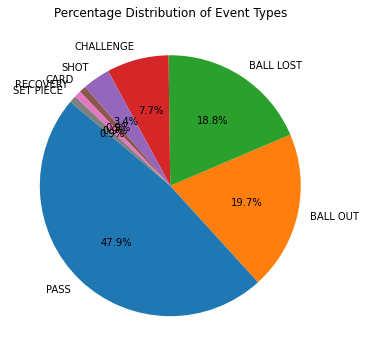

In [15]:
# Pie Chart for percentage distribution of event types
event_type_counts = home_event['Type'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

Fill NA values in Subtype and To columns

In [16]:
# Imputing missing values with 'Unknown'
home_event['Subtype'].fillna('Unknown', inplace=True)
home_event['To'].fillna('Unknown', inplace=True)

# Verify the imputation
imputation_check = home_event[['Subtype', 'To']].isnull().sum()
imputation_check

Subtype    0
To         0
dtype: int64

Players Involvement In Leading Events for Home 

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


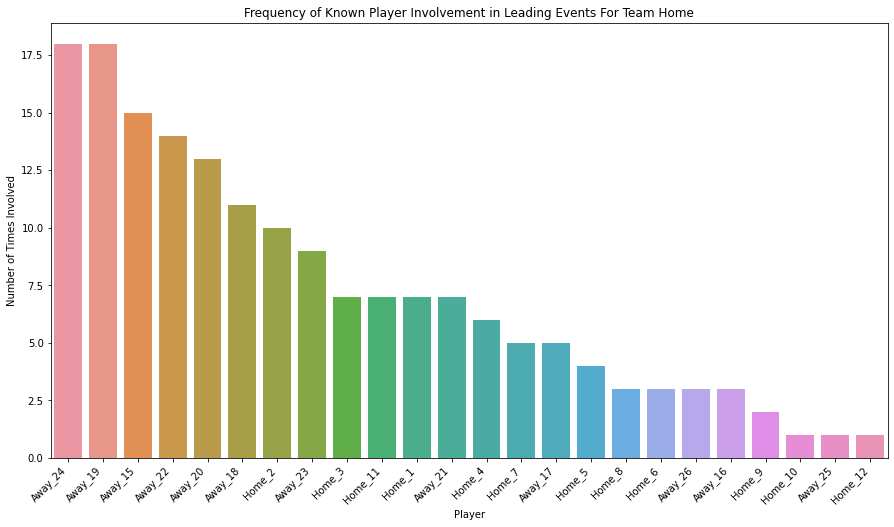

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'home_event' is your DataFrame
combined_players = home_event['From'].append(home_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

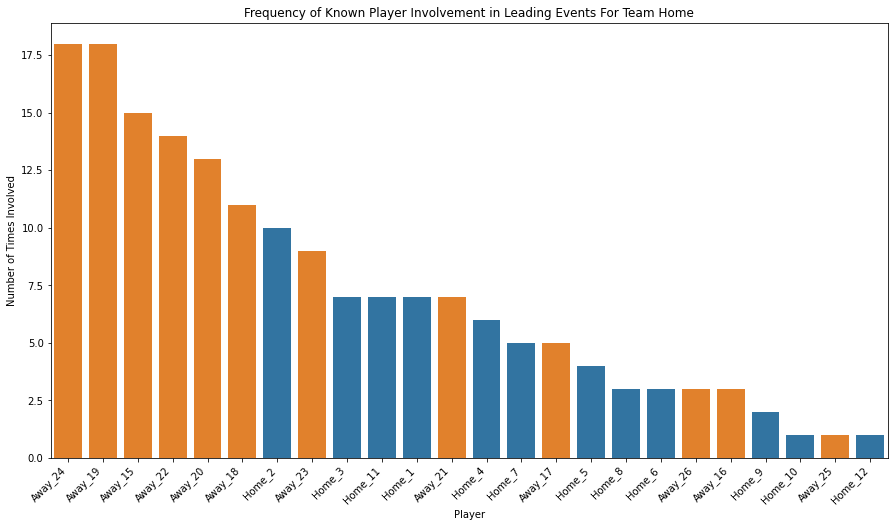

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'home_event' is your DataFrame
combined_players = home_event['From'].append(home_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

### Clustering Process

##### Data Preparation

In [19]:
from sklearn.preprocessing import OneHotEncoder

# Selecting the relevant columns for clustering
features = home_event[['Type', 'Subtype', 'From', 'To']]

# Applying one-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(features)

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

# Display the first few rows of the encoded DataFrame
encoded_df.head()

,Type_BALL LOST,Type_BALL OUT,Type_CARD,Type_CHALLENGE,Type_PASS,Type_RECOVERY,Type_SET PIECE,Type_SHOT,Subtype_AERIAL-LOST,Subtype_CLEARANCE,Subtype_CROSS,Subtype_GROUND,Subtype_GROUND-FAULT-LOST,Subtype_GROUND-LOST,Subtype_GROUND-WON,Subtype_HEAD,Subtype_HEAD-CLEARANCE,Subtype_HEAD-INTERCEPTION,Subtype_INTERCEPTION,Subtype_OFF TARGET-HEAD-OUT,Subtype_OFF TARGET-OUT,Subtype_TACKLE-LOST,Subtype_THROW IN,Subtype_Unknown,Subtype_YELLOW,From_Player 26,From_Player1,From_Player10,From_Player11,From_Player15,From_Player16,From_Player17,From_Player18,From_Player19,From_Player2,From_Player20,From_Player21,From_Player22,From_Player23,From_Player24,From_Player25,From_Player3,From_Player4,From_Player5,From_Player6,From_Player7,From_Player8,From_Player9,To_Player 26,To_Player1,To_Player11,To_Player12,To_Player15,To_Player18,To_Player19,To_Player2,To_Player20,To_Player22,To_Player23,To_Player24,To_Player3,To_Player7,To_Unknown
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Clustering K-Means

In [20]:
from sklearn.cluster import KMeans

# Clustering using K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_df)

# Adding the cluster labels to the original dataframe
home_event['Cluster'] = clusters

# Displaying a few rows of the dataframe with cluster labels
home_event.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Cluster
0,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,Unknown,0.72,0.04,0.87,0.13,3
1,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,Unknown,0.72,0.04,0.87,0.13,3
2,Home,PASS,Unknown,1,2511,100.44,2546,101.84,Player4,Player3,0.61,0.97,0.76,0.87,2
3,Home,PASS,Unknown,1,3248,129.92,3311,132.44,Player3,Player11,0.58,0.27,0.86,0.45,2
4,Away,PASS,Unknown,1,14189,567.56,14234,569.36,Player15,Player19,0.62,0.99,0.75,0.86,4


##### Analysis of clusters

In [21]:
# Analyzing each cluster
cluster_analysis = []

for cluster_num in range(5):
    cluster_data = home_event[home_event['Cluster'] == cluster_num]
    
    # Most common event types in this cluster
    common_types = cluster_data['Type'].value_counts().head(3)
    
    # Most common 'From' players in this cluster
    common_from_players = cluster_data['From'].value_counts().head(3)
    
    # Most common 'To' players in this cluster
    common_to_players = cluster_data['To'].value_counts().head(3)

    cluster_analysis.append({
        'Cluster': cluster_num,
        'Most Common Event Types': common_types,
        'Most Common From Players': common_from_players,
        'Most Common To Players': common_to_players
    })

# Display the analysis for each cluster
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df.set_index('Cluster', inplace=True)
cluster_analysis_df

,Most Common Event Types,Most Common From Players,Most Common To Players
Cluster,,,
0,CHALLENGE 9 SHOT 4 CARD 1 N...,Player23 2 Player19 2 Player18 2 Name...,"Unknown 15 Name: To, dtype: int64"
1,BALL OUT 23 BALL LOST 5 RECOVERY ...,Player17 4 Player22 4 Player24 3 Name...,"Unknown 29 Name: To, dtype: int64"
2,"PASS 46 Name: Type, dtype: int64",Player15 5 Player20 5 Player21 4 Name...,Player24 10 Player11 6 Player2 6 N...
3,"BALL LOST 17 Name: Type, dtype: int64",Player24 4 Player16 2 Player20 2 Name...,"Unknown 17 Name: To, dtype: int64"
4,"PASS 10 Name: Type, dtype: int64",Player15 4 Player22 2 Player21 2 Name...,"Player19 10 Name: To, dtype: int64"


##### Visualize clusters

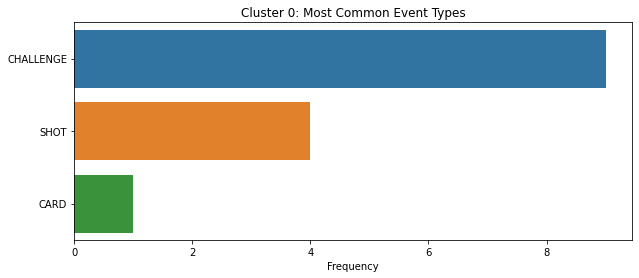

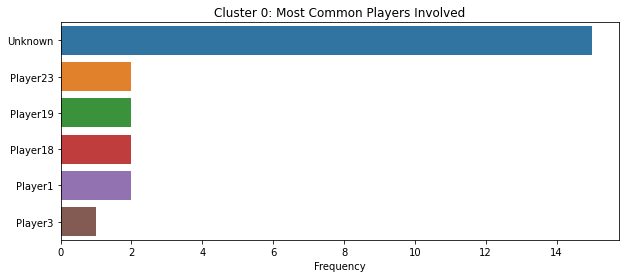

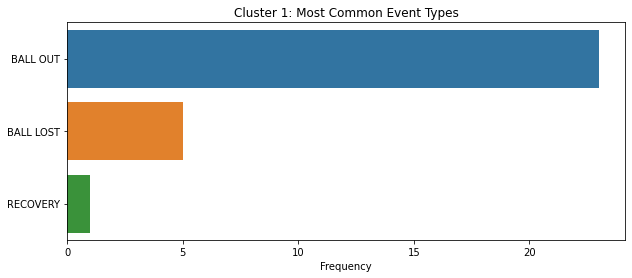

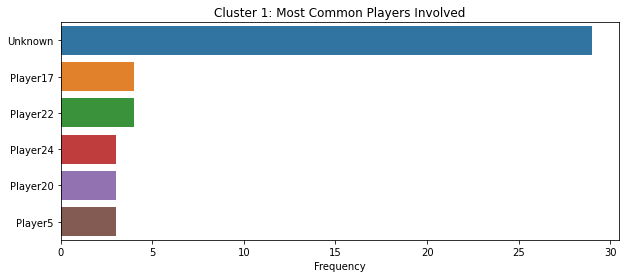

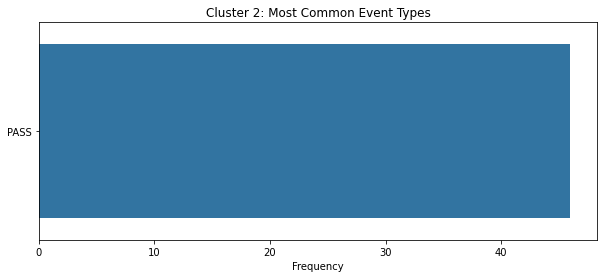

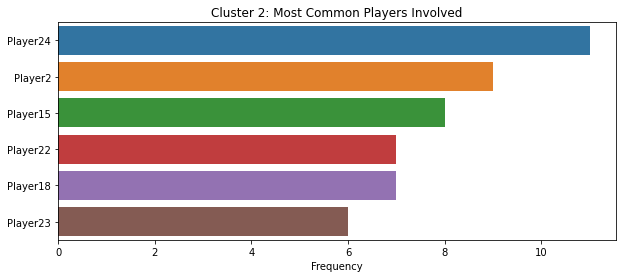

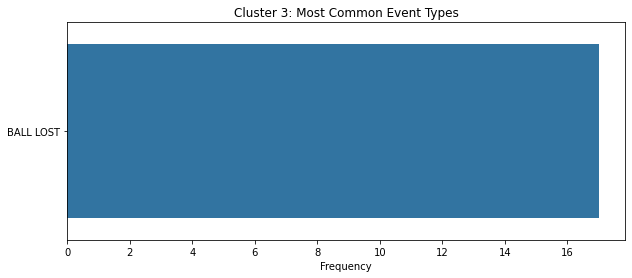

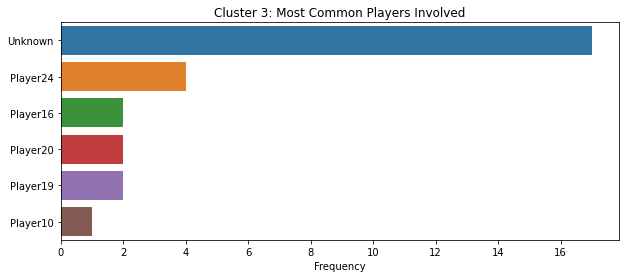

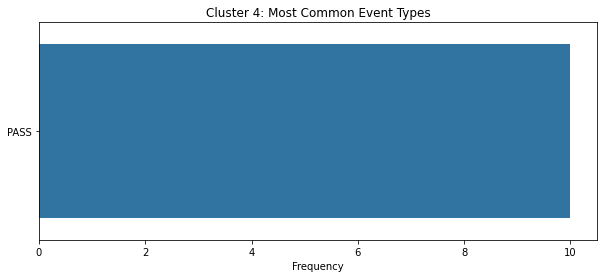

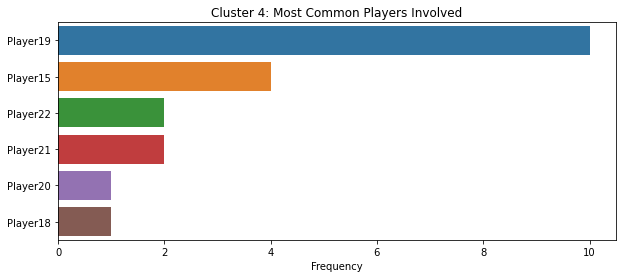

In [22]:
import seaborn as sns

def plot_cluster_data(cluster_num, cluster_data, title):
    """
    Plot the data for a given cluster.
    """
    plt.figure(figsize=(10, 4))
    sns.barplot(x=cluster_data.values, y=cluster_data.index)
    plt.title(f"Cluster {cluster_num}: {title}")
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

# Plotting the most common event types and players for each cluster
for cluster_num in range(5):
    cluster = home_event[home_event['Cluster'] == cluster_num]

    # Most common event types
    common_types = cluster['Type'].value_counts().head(3)
    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')

    # Combining 'From' and 'To' players for a comprehensive view
    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)
    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

Find Away Team High Pressure moment #1

In [23]:
away_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1))]
away_moments.columns

Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')

In [24]:
away_moments.to_csv('away_moments.csv', index=False)

Find the exact event before the high pressure moment happen

In [25]:
away_event = pd.DataFrame(columns=events.columns)

for index, row in away_moments.iterrows():
    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row
        if e_index > 0:
            current_start_time = e_row['Start Time [s]']
            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']
            home_time = row['Time [s]']

            # Check both the current and previous start times against home_time
            if current_start_time >= home_time and previous_start_time < home_time:
                away_event = away_event.append(events.iloc[e_index - 1], ignore_index=True)

away_event
away_event.to_csv('away_event.csv', index=False)

Visualize Leading Events for Team Away

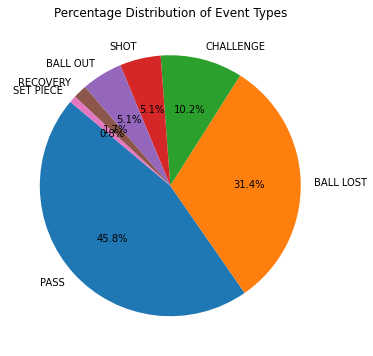

In [26]:
# Pie Chart for percentage distribution of event types
event_type_counts = away_event['Type'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentage Distribution of Event Types')
plt.show()

Fill NA values in Subtype and To columns

In [27]:
# Imputing missing values with 'Unknown'
away_event['Subtype'].fillna('Unknown', inplace=True)
away_event['To'].fillna('Unknown', inplace=True)

# Verify the imputation
imputation_check = away_event[['Subtype', 'To']].isnull().sum()
imputation_check

Subtype    0
To         0
dtype: int64

Players Involvement In Leading Events for Away 

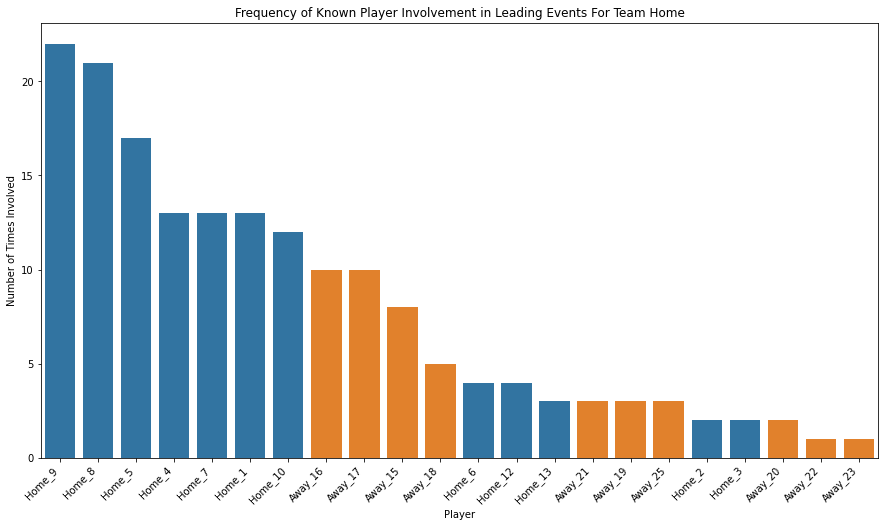

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'home_event' is your DataFrame
combined_players = away_event['From'].append(away_event['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

### Clustering Process

##### Data Preparation

In [29]:
from sklearn.preprocessing import OneHotEncoder

# Selecting the relevant columns for clustering
features = away_event[['Type', 'Subtype', 'From', 'To']]

# Applying one-hot encoding
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(features)

# Convert the encoded features into a DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

# Display the first few rows of the encoded DataFrame
encoded_df.head()

,Type_BALL LOST,Type_BALL OUT,Type_CHALLENGE,Type_PASS,Type_RECOVERY,Type_SET PIECE,Type_SHOT,Subtype_AERIAL-FAULT-LOST,Subtype_AERIAL-LOST,Subtype_CROSS-INTERCEPTION,Subtype_DEEP BALL,Subtype_FORCED,Subtype_FREE KICK,Subtype_GROUND-FAULT-WON,Subtype_GROUND-LOST,Subtype_GROUND-WON,Subtype_HAND BALL,Subtype_HEAD-INTERCEPTION,Subtype_HEAD-OFF TARGET-OUT,Subtype_INTERCEPTION,Subtype_OFF TARGET-OUT,Subtype_OFFSIDE,Subtype_ON TARGET-SAVED,Subtype_TACKLE-LOST,Subtype_THEFT,Subtype_Unknown,From_Player1,From_Player10,From_Player12,From_Player13,From_Player15,From_Player16,From_Player17,From_Player18,From_Player19,From_Player2,From_Player20,From_Player21,From_Player22,From_Player23,From_Player25,From_Player3,From_Player4,From_Player5,From_Player6,From_Player7,From_Player8,From_Player9,To_Player1,To_Player10,To_Player12,To_Player16,To_Player17,To_Player19,To_Player20,To_Player21,To_Player25,To_Player5,To_Player7,To_Player8,To_Player9,To_Unknown
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### Clustering K-Means

In [30]:
from sklearn.cluster import KMeans

# Clustering using K-Means with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(encoded_df)

# Adding the cluster labels to the original dataframe
away_event['Cluster'] = clusters

# Displaying a few rows of the dataframe with cluster labels
away_event.head()

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Cluster
0,Away,PASS,Unknown,1,768,30.72,808,32.32,Player16,Player17,0.29,0.84,0.23,0.53,0
1,Away,PASS,Unknown,1,956,38.24,1016,40.64,Player15,Player16,0.28,0.99,0.15,0.90,0
2,Home,BALL LOST,INTERCEPTION,1,2997,119.88,3037,121.48,Player1,Unknown,0.34,0.04,0.19,0.29,1
3,Home,PASS,Unknown,1,3828,153.12,3875,155.00,Player8,Player7,0.28,0.94,0.15,0.93,0
4,Home,PASS,Unknown,1,4132,165.28,4177,167.08,Player5,Player1,0.31,0.55,0.21,0.07,0


##### Analysis of clusters

In [31]:
# Analyzing each cluster
cluster_analysis = []

for cluster_num in range(5):
    cluster_data = away_event[away_event['Cluster'] == cluster_num]
    
    # Most common event types in this cluster
    common_types = cluster_data['Type'].value_counts().head(3)
    
    # Most common 'From' players in this cluster
    common_from_players = cluster_data['From'].value_counts().head(3)
    
    # Most common 'To' players in this cluster
    common_to_players = cluster_data['To'].value_counts().head(3)

    cluster_analysis.append({
        'Cluster': cluster_num,
        'Most Common Event Types': common_types,
        'Most Common From Players': common_from_players,
        'Most Common To Players': common_to_players
    })

# Display the analysis for each cluster
cluster_analysis_df = pd.DataFrame(cluster_analysis)
cluster_analysis_df.set_index('Cluster', inplace=True)
cluster_analysis_df

,Most Common Event Types,Most Common From Players,Most Common To Players
Cluster,,,
0,"PASS 54 Name: Type, dtype: int64",Player5 8 Player15 6 Player4 6 Name...,Player8 11 Player1 8 Player9 7 Name...
1,BALL LOST 27 SET PIECE 1 RECOVERY ...,Player5 6 Player9 5 Player8 4 Name: F...,"Unknown 29 Name: To, dtype: int64"
2,"CHALLENGE 12 Name: Type, dtype: int64",Player10 3 Player16 2 Player9 1 Name...,"Unknown 12 Name: To, dtype: int64"
3,BALL LOST 10 BALL OUT 6 RECOVERY ...,Player9 2 Player4 2 Player10 2 Name...,"Unknown 17 Name: To, dtype: int64"
4,"SHOT 6 Name: Type, dtype: int64",Player9 3 Player7 1 Player5 1 Name: F...,"Unknown 6 Name: To, dtype: int64"


##### Visualize clusters

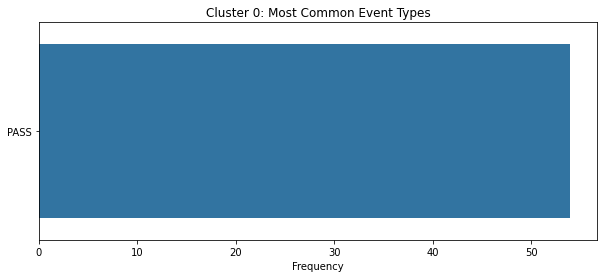

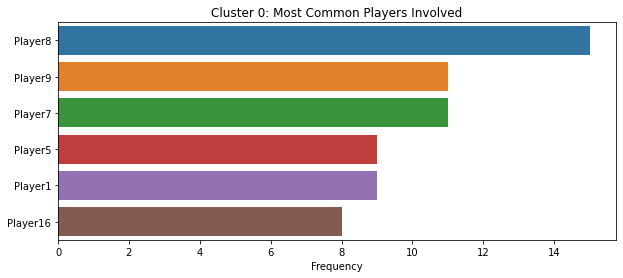

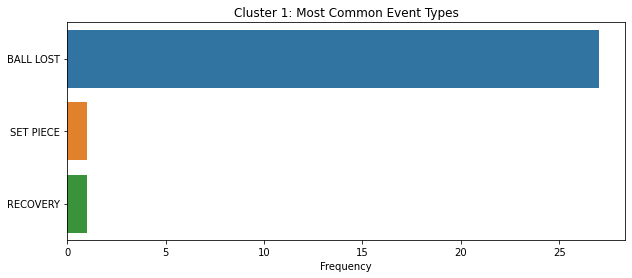

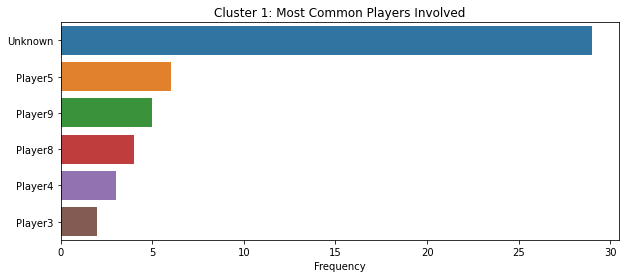

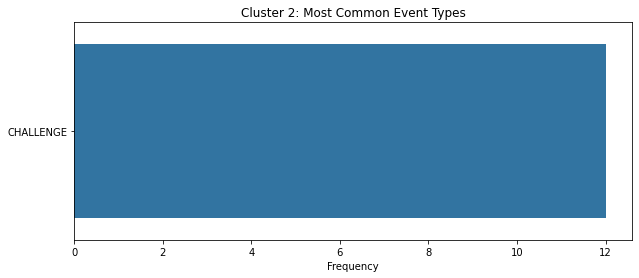

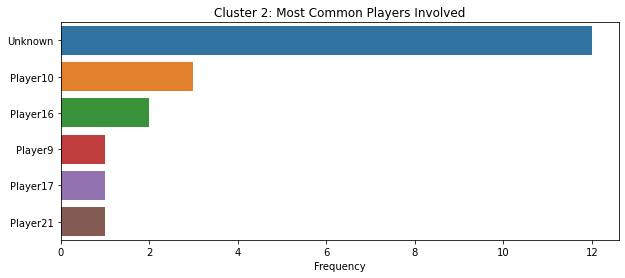

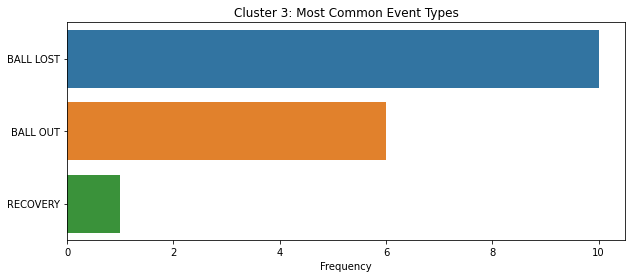

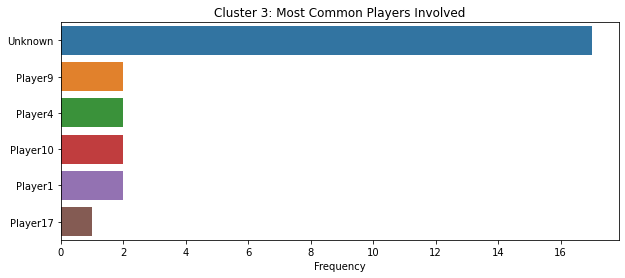

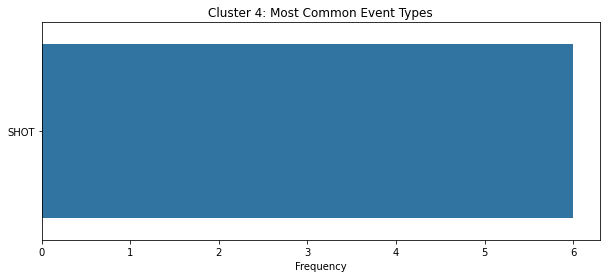

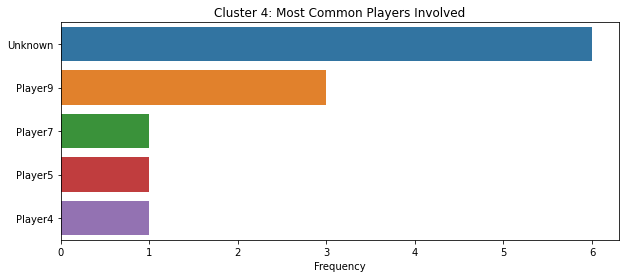

In [32]:
import seaborn as sns

def plot_cluster_data(cluster_num, cluster_data, title):
    """
    Plot the data for a given cluster.
    """
    plt.figure(figsize=(10, 4))
    sns.barplot(x=cluster_data.values, y=cluster_data.index)
    plt.title(f"Cluster {cluster_num}: {title}")
    plt.xlabel('Frequency')
    plt.ylabel('')
    plt.show()

# Plotting the most common event types and players for each cluster
for cluster_num in range(5):
    cluster = away_event[away_event['Cluster'] == cluster_num]

    # Most common event types
    common_types = cluster['Type'].value_counts().head(3)
    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')

    # Combining 'From' and 'To' players for a comprehensive view
    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)
    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

Find up to three events leading up to each moment within a specified time window (15 s)

In [35]:
def find_leading_events(moment_df, events_df, time_window):
    leading_events = []

    for _, moment in moment_df.iterrows():
        period = moment['Period']
        moment_time = moment['Time [s]']

        # Filtering events that are in the same period and within the time window
        valid_events = events_df[
            (events_df['Period'] == period) &
            (events_df['Start Time [s]'] <= moment_time) &
            (events_df['Start Time [s]'] >= moment_time - time_window)
        ]

        # Sort by time descending (most recent first) and take up to 3 events
        valid_events = valid_events.sort_values(by='Start Time [s]', ascending=False).head(3)

        # Add moment identifier columns to each valid event
        valid_events['Moment Period'] = period
        valid_events['Moment Time [s]'] = moment_time

        leading_events.append(valid_events)

    return pd.concat(leading_events, ignore_index=True)

# Define the time window (15 seconds)
time_window = 15

# Find leading events for home moments
leading_events_home = find_leading_events(home_moments, events, time_window)

leading_events_home.to_csv("leading_events_home.csv")

In [36]:
leading_events_home

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Moment Period,Moment Time [s]
0,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,0.72,0.04,0.87,0.13,1.0,55.96
1,Away,PASS,NaN,1,1289,51.56,1319,52.76,Player18,Player24,0.49,0.18,0.62,0.18,1.0,55.96
2,Away,PASS,NaN,1,1170,46.80,1224,48.96,Player20,Player18,0.36,0.65,0.36,0.24,1.0,55.96
3,Home,RECOVERY,INTERCEPTION,1,1431,57.24,1431,57.24,Player1,NaN,0.87,0.13,NaN,NaN,1.0,57.24
4,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,0.72,0.04,0.87,0.13,1.0,57.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,Away,PASS,NaN,2,135929,5437.16,135985,5439.40,Player21,Player23,0.30,0.77,0.13,0.88,2.0,5437.80
323,Away,CHALLENGE,TACKLE-ADVANTAGE-WON,2,135910,5436.40,135910,5436.40,Player21,NaN,0.30,0.75,NaN,NaN,2.0,5437.80
324,Away,PASS,NaN,2,135876,5435.04,135894,5435.76,Player19,Player21,0.33,0.87,0.29,0.75,2.0,5437.80
325,Home,RECOVERY,NaN,2,136961,5478.44,136961,5478.44,Player11,NaN,0.06,0.59,NaN,NaN,2.0,5478.44


In [37]:
# Find leading events for away moments
leading_events_away = find_leading_events(away_moments, events, time_window)

leading_events_away.head()


,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Moment Period,Moment Time [s]
0,Away,PASS,NaN,1,768,30.72,808,32.32,Player16,Player17,0.29,0.84,0.23,0.53,1.0,31.68
1,Away,SET PIECE,THROW IN,1,672,26.88,672,26.88,Player15,NaN,NaN,NaN,NaN,NaN,1.0,31.68
2,Away,PASS,NaN,1,672,26.88,722,28.88,Player15,Player16,0.50,1.01,0.33,0.92,1.0,31.68
3,Away,PASS,NaN,1,956,38.24,1016,40.64,Player15,Player16,0.28,0.99,0.15,0.90,1.0,38.72
4,Away,PASS,NaN,1,925,37.00,947,37.88,Player16,Player15,0.23,0.87,0.28,0.99,1.0,38.72


Create triples of leading events

In [44]:
def create_event_triples(triple_leading_events):

    # Group by moment
    grouped = triple_leading_events.groupby(['Moment Period', 'Moment Time [s]'])

    # Create triples for each group
    triples = []
    for _, group in grouped:
        events = group.to_dict('records')
        triple = [events[i] if i < len(events) else None for i in range(3)]
        triples.append(triple)

    return pd.DataFrame(triples, columns=['Event 1', 'Event 2', 'Event 3'])

# Create event triples for home and away
triples_home = create_event_triples(leading_events_home)
triples_away = create_event_triples(leading_events_away)

triples_home.head(), triples_away.head()
triples_home.drop([])

0      {'Team': 'Away', 'Type': 'BALL LOST', 'Subtype...
1      {'Team': 'Home', 'Type': 'RECOVERY', 'Subtype'...
2      {'Team': 'Home', 'Type': 'PASS', 'Subtype': na...
3      {'Team': 'Home', 'Type': 'PASS', 'Subtype': na...
4      {'Team': 'Away', 'Type': 'PASS', 'Subtype': na...
                             ...                        
112    {'Team': 'Away', 'Type': 'PASS', 'Subtype': na...
113    {'Team': 'Away', 'Type': 'BALL LOST', 'Subtype...
114    {'Team': 'Away', 'Type': 'PASS', 'Subtype': na...
115    {'Team': 'Away', 'Type': 'PASS', 'Subtype': na...
116    {'Team': 'Home', 'Type': 'RECOVERY', 'Subtype'...
Name: Event 1, Length: 117, dtype: object

In [39]:
# Re-define the create_event_triples function to include only the 'Type' of each event
def create_event_type_triples(triple_leading_events):
    """
    Create triples of event types for each moment.

    :param triple_leading_events: DataFrame containing leading events for each moment.
    :return: DataFrame with triples of event types for each moment.
    """
    # Group by moment
    grouped = triple_leading_events.groupby(['Moment Period', 'Moment Time [s]'])

    # Create triples for each group
    triples = []
    for _, group in grouped:
        event_types = group['Type'].tolist()
        triple = [event_types[i] if i < len(event_types) else None for i in range(3)]
        triples.append(triple)

    return pd.DataFrame(triples, columns=['1 Event Before', '2 Events Before', '3 Events Before'])

# Create event type triples for home and away
type_triples_home = create_event_type_triples(leading_events_home)
type_triples_away = create_event_type_triples(leading_events_away)

type_triples_home.head(), type_triples_away.head()


(  1 Event Before 2 Events Before 3 Events Before
 0      BALL LOST            PASS            PASS
 1       RECOVERY       BALL LOST            PASS
 2           PASS            PASS        RECOVERY
 3           PASS        RECOVERY       BALL LOST
 4           PASS            PASS            PASS,
   1 Event Before 2 Events Before 3 Events Before
 0           PASS       SET PIECE            PASS
 1           PASS            PASS            PASS
 2      BALL LOST            PASS            PASS
 3           PASS            PASS            PASS
 4           PASS            PASS            PASS)

In [ ]:
type_triples_home.to_csv("type_triples_home.csv")

In [ ]:
type_triples_away.to_csv("type_triples_away.csv")

In [ ]:
# Frequency analysis for each event position in both datasets
freq_home_1 = type_triples_home['1 Event Before'].value_counts()
freq_home_2 = type_triples_home['2 Events Before'].value_counts()
freq_home_3 = type_triples_home['3 Events Before'].value_counts()

freq_away_1 = type_triples_away['1 Event Before'].value_counts()
freq_away_2 = type_triples_away['2 Events Before'].value_counts()
freq_away_3 = type_triples_away['3 Events Before'].value_counts()

(freq_home_1, freq_home_2, freq_home_3, freq_away_1, freq_away_2, freq_away_3)

(PASS         53
 RECOVERY     25
 SET PIECE    18
 BALL LOST     9
 CHALLENGE     6
 BALL OUT      6
 Name: 1 Event Before, dtype: int64,
 PASS         76
 CHALLENGE    12
 RECOVERY     10
 BALL LOST    10
 SET PIECE     3
 SHOT          2
 BALL OUT      1
 Name: 2 Events Before, dtype: int64,
 PASS              41
 CHALLENGE         13
 BALL LOST         12
 RECOVERY           6
 SET PIECE          2
 BALL OUT           2
 FAULT RECEIVED     1
 Name: 3 Events Before, dtype: int64,
 PASS         51
 RECOVERY     29
 SET PIECE    15
 CHALLENGE    12
 BALL LOST    11
 Name: 1 Event Before, dtype: int64,
 PASS         64
 BALL LOST    22
 RECOVERY     16
 CHALLENGE     9
 SET PIECE     3
 SHOT          2
 Name: 2 Events Before, dtype: int64,
 PASS         51
 BALL LOST    13
 CHALLENGE    12
 RECOVERY      7
 SET PIECE     2
 BALL OUT      2
 SHOT          1
 Name: 3 Events Before, dtype: int64)

In [ ]:
from collections import Counter

# Function to count sequences
def count_sequences(df):
    sequences = df.apply(lambda row: tuple(row.dropna().values), axis=1)
    return Counter(sequences)

# Counting sequences for home and away datasets
sequence_counts_home = count_sequences(type_triples_home.iloc[:, 1:])
sequence_counts_away = count_sequences(type_triples_away.iloc[:, 1:])

# Displaying the most common sequences
most_common_home = sequence_counts_home.most_common(5)
most_common_away = sequence_counts_away.most_common(5)

most_common_home, most_common_away

([(('PASS',), 29),
  (('PASS', 'PASS'), 29),
  (('PASS', 'BALL LOST'), 6),
  (('BALL LOST',), 6),
  (('CHALLENGE', 'CHALLENGE'), 6)],
 [(('PASS', 'PASS'), 40),
  (('PASS',), 13),
  (('BALL LOST',), 11),
  (('PASS', 'CHALLENGE'), 4),
  (('RECOVERY', 'BALL LOST'), 4)])

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


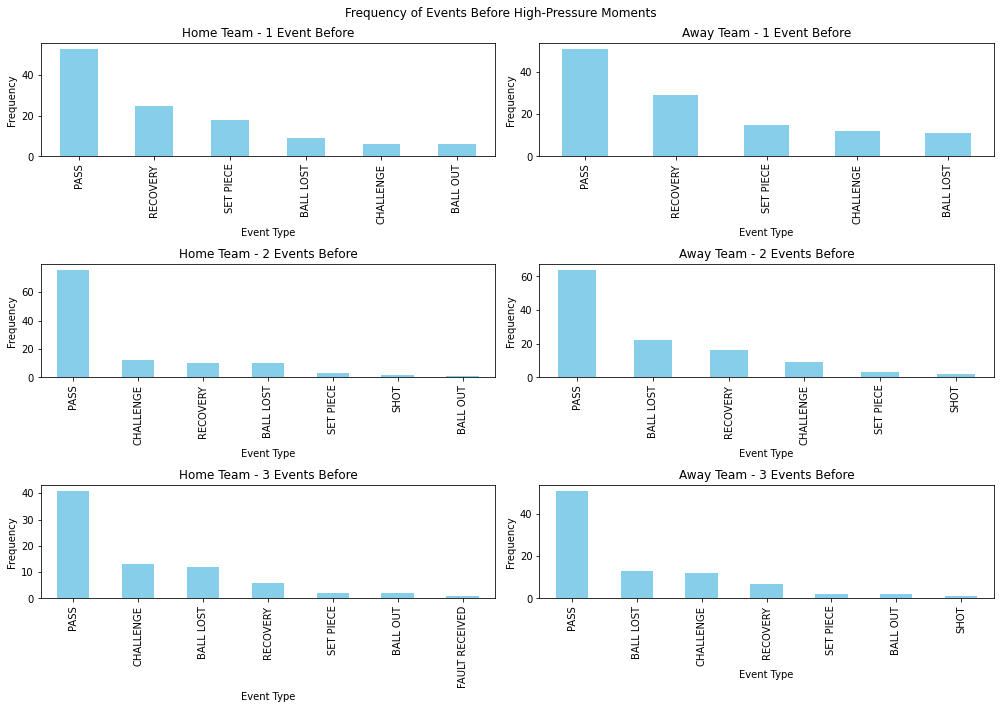

In [ ]:
import matplotlib.pyplot as plt

# Function to plot frequency bar charts
def plot_event_frequencies(freq_data, title, ax):
    freq_data.plot(kind='bar', ax=ax, color='skyblue')
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Event Type')

# Creating subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 10), tight_layout=True)
fig.suptitle('Frequency of Events Before High-Pressure Moments')

# Plotting for Home Team
plot_event_frequencies(freq_home_1, 'Home Team - 1 Event Before', axes[0, 0])
plot_event_frequencies(freq_home_2, 'Home Team - 2 Events Before', axes[1, 0])
plot_event_frequencies(freq_home_3, 'Home Team - 3 Events Before', axes[2, 0])

# Plotting for Away Team
plot_event_frequencies(freq_away_1, 'Away Team - 1 Event Before', axes[0, 1])
plot_event_frequencies(freq_away_2, 'Away Team - 2 Events Before', axes[1, 1])
plot_event_frequencies(freq_away_3, 'Away Team - 3 Events Before', axes[2, 1])

plt.show()

In [ ]:
triples_home.to_csv("triples_home")
triples_away.to_csv("triples_away")

In [ ]:
leading_events_away
leading_events_home

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y,Moment Period,Moment Time [s]
0,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,0.72,0.04,0.87,0.13,1.0,55.96
1,Away,PASS,NaN,1,1289,51.56,1319,52.76,Player18,Player24,0.49,0.18,0.62,0.18,1.0,55.96
2,Home,RECOVERY,INTERCEPTION,1,1431,57.24,1431,57.24,Player1,NaN,0.87,0.13,NaN,NaN,1.0,57.24
3,Away,BALL LOST,INTERCEPTION,1,1392,55.68,1429,57.16,Player24,NaN,0.72,0.04,0.87,0.13,1.0,57.24
4,Away,PASS,NaN,1,1289,51.56,1319,52.76,Player18,Player24,0.49,0.18,0.62,0.18,1.0,57.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,Away,PASS,NaN,2,135929,5437.16,135985,5439.40,Player21,Player23,0.30,0.77,0.13,0.88,2.0,5437.80
304,Away,CHALLENGE,TACKLE-ADVANTAGE-WON,2,135910,5436.40,135910,5436.40,Player21,NaN,0.30,0.75,NaN,NaN,2.0,5437.80
305,Away,PASS,NaN,2,135876,5435.04,135894,5435.76,Player19,Player21,0.33,0.87,0.29,0.75,2.0,5437.80
306,Home,RECOVERY,NaN,2,136961,5478.44,136961,5478.44,Player11,NaN,0.06,0.59,NaN,NaN,2.0,5478.44


In [ ]:
leading_events_away.drop(['Start Frame', 'End Frame', 'Start Time [s]', 'End Time [s]', 'Period', 'Start X', 'Start Y', 'End X', 'End Y'], axis=1, inplace=True)
leading_events_away

In [50]:
leading_events_away.to_csv('leading_events_away.csv')

In [52]:
# Creating the 'Type_s' column by combining 'Type' and 'Subtype'
leading_events_away['Type_s'] = leading_events_away.apply(lambda row: f"{row['Type']} - {row['Subtype']}" if pd.notna(row['Subtype']) else row['Type'], axis=1)

# Display the first few rows to confirm the new column
leading_events_away

,Team,Type,Subtype,From,To,Moment Period,Moment Time [s],Type_s
0,Away,PASS,NaN,Player16,Player17,1.0,31.68,PASS
1,Away,SET PIECE,THROW IN,Player15,NaN,1.0,31.68,SET PIECE - THROW IN
2,Away,PASS,NaN,Player15,Player16,1.0,31.68,PASS
3,Away,PASS,NaN,Player15,Player16,1.0,38.72,PASS
4,Away,PASS,NaN,Player16,Player15,1.0,38.72,PASS
...,...,...,...,...,...,...,...,...
329,Away,PASS,NaN,Player15,Player16,2.0,5375.28,PASS
330,Away,PASS,NaN,Player23,Player15,2.0,5375.28,PASS
331,Away,PASS,NaN,Player20,Player23,2.0,5375.28,PASS
332,Home,SET PIECE,FREE KICK,Player9,NaN,2.0,5595.92,SET PIECE - FREE KICK


In [68]:
# Grouping the data by 'Moment Time [s]' and creating triples of 'Type_s'
triples_away = leading_events_away.groupby('Moment Time [s]')['Type_s'].apply(lambda x: list(x)[:3])

# Convert the Series to a DataFrame for easier visualization
triples_away_df = pd.DataFrame(triples_away.tolist(), index=triples_away.index, columns=['Event 1', 'Event 2', 'Event 3'])

# Display the first few rows of the triples DataFrame
triples_away_df

,Event 1,Event 2,Event 3
Moment Time [s],,,
31.68,PASS,SET PIECE - THROW IN,PASS
38.72,PASS,PASS,PASS
120.88,BALL LOST - INTERCEPTION,PASS,PASS
153.52,PASS,PASS,PASS
166.40,PASS,PASS,PASS
...,...,...,...
5155.92,PASS,PASS,SET PIECE - FREE KICK
5184.12,PASS,PASS,PASS
5187.76,PASS,PASS,PASS


Leading Events Type and Subtype Visualization For Team Away

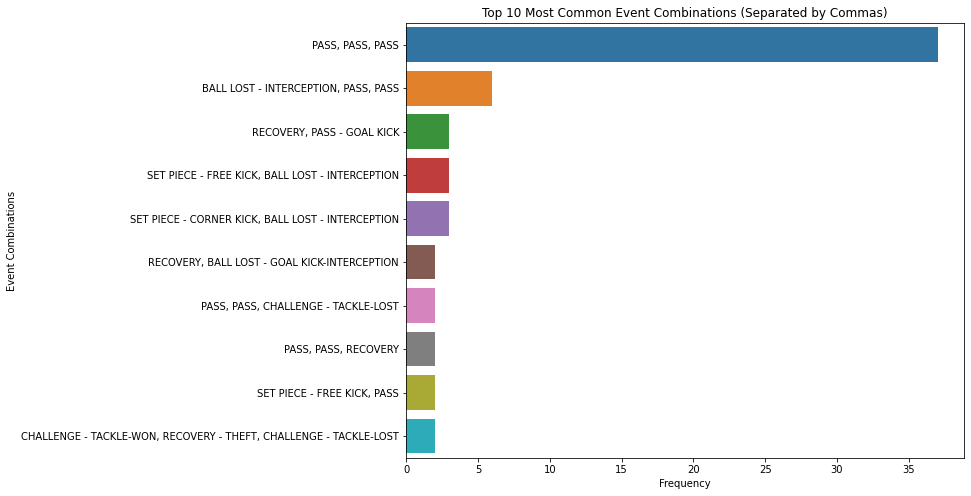

In [73]:
# Function to create pairs or singles from triples with ',' as a separator
def create_combinations(triple):
    # Filter out None values and join with ','
    filtered_events = [event for event in triple if event is not None]
    return ', '.join(filtered_events)

# Applying the function to create pairs or singles from triples with ',' as a separator
type_combinations = triples_away.apply(create_combinations)

# Counting the frequency of each adjusted triple (or pair/single) with ',' as a separator
type_combinations_count = type_combinations.value_counts()

# Creating a bar plot for the most common Leading Events for Away
plt.figure(figsize=(10, 8))
sns.barplot(y=type_combinations_count.index[:10], x=type_combinations_count.values[:10])  # Displaying top 10
plt.title('Top 10 Most Common Event Combinations (Separated by Commas)')
plt.xlabel('Frequency')
plt.ylabel('Event Combinations')
plt.show()

In [79]:
tracking_data.columns

Index(['Period', 'Time [s]', 'Away_25_x', 'Away_25_y', 'Away_15_x',
       'Away_15_y', 'Away_16_x', 'Away_16_y', 'Away_17_x', 'Away_17_y',
       'Away_18_x', 'Away_18_y', 'Away_19_x', 'Away_19_y', 'Away_20_x',
       'Away_20_y', 'Away_21_x', 'Away_21_y', 'Away_22_x', 'Away_22_y',
       'Away_23_x', 'Away_23_y', 'Away_24_x', 'Away_24_y', 'Away_26_x',
       'Away_26_y', 'Home_11_x', 'Home_11_y', 'Home_1_x', 'Home_1_y',
       'Home_2_x', 'Home_2_y', 'Home_3_x', 'Home_3_y', 'Home_4_x', 'Home_4_y',
       'Home_5_x', 'Home_5_y', 'Home_6_x', 'Home_6_y', 'Home_7_x', 'Home_7_y',
       'Home_8_x', 'Home_8_y', 'Home_9_x', 'Home_9_y', 'Home_10_x',
       'Home_10_y', 'Home_12_x', 'Home_12_y', 'Home_13_x', 'Home_13_y',
       'Home_14_x', 'Home_14_y', 'ball_x', 'ball_y'],
      dtype='object')

In [81]:
# Separate the data by period
period_1_data = tracking_data[tracking_data['Period'] == 1]
period_2_data = tracking_data[tracking_data['Period'] == 2]


In [83]:
import numpy as np

# Example for Home team in period 1
home_columns = [col for col in period_1_data.columns if 'Home' in col]
home_positions = period_1_data[home_columns]

# Reshape the data to have all x and y positions in two columns
home_x = home_positions.filter(like='_x').values.flatten()
home_y = home_positions.filter(like='_y').values.flatten()

# Remove NaN values if any
home_x = home_x[~np.isnan(home_x)]
home_y = home_y[~np.isnan(home_y)]


c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


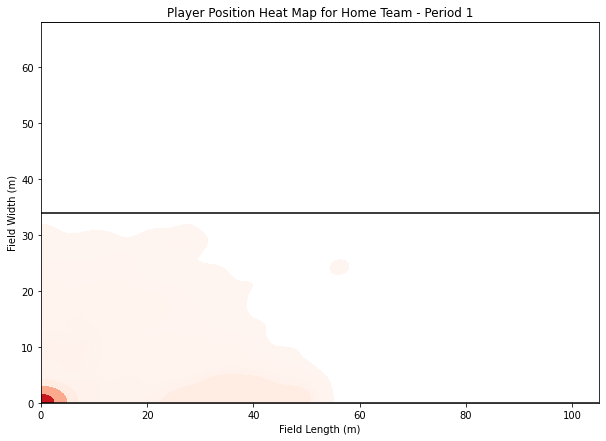

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the dimensions of a soccer field
field_dimen = (105, 68)  # in meters, standard soccer field dimensions

# Create a figure
plt.figure(figsize=(10, 7))

# Create a heat map
sns.kdeplot(home_x, home_y, cmap="Reds", shade=True, shade_lowest=False)

# Set the limits to the size of the field
plt.xlim(0, field_dimen[0])
plt.ylim(0, field_dimen[1])

# Add field markings (optional)
plt.axhline(y=field_dimen[1]/2, color='black', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-')
plt.axhline(y=field_dimen[1], color='black', linestyle='-')

# Add title and labels
plt.title('Player Position Heat Map for Home Team - Period 1')
plt.xlabel('Field Length (m)')
plt.ylabel('Field Width (m)')

# Show the plot
plt.show()


In [88]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import numpy as np

# Re-encoding the 'Type_s' column
le_type_s = LabelEncoder()
leading_events_away['Type_s_encoded'] = le_type_s.fit_transform(leading_events_away['Type_s'])

# Re-encoding the 'From' and 'To' columns, handling NaN values
le_player = LabelEncoder()
all_players = pd.concat([leading_events_away['From'], leading_events_away['To']]).dropna().unique()
le_player.fit(all_players)
leading_events_away['From_encoded'] = le_player.transform(leading_events_away['From'])
leading_events_away['To_encoded'] = leading_events_away['To'].map(lambda x: le_player.transform([x])[0] if pd.notna(x) else np.nan)

# Preparing the final dataset for clustering
cluster_data_away = leading_events_away[['Type_s_encoded', 'From_encoded', 'To_encoded']].fillna(-1)

# Re-performing clustering
kmeans_away = KMeans(n_clusters=5, random_state=0).fit(cluster_data_away)

# Adding the cluster labels to the original dataframe
leading_events_away['Cluster'] = kmeans_away.labels_

# Attempting to display the first few rows again
leading_events_away.head()

,Team,Type,Subtype,From,To,Moment Period,Moment Time [s],Type_s,Type_s_encoded,From_encoded,To_encoded,Cluster
0,Away,PASS,NaN,Player16,Player17,1.0,31.68,PASS,19,8,9.0,0
1,Away,SET PIECE,THROW IN,Player15,NaN,1.0,31.68,SET PIECE - THROW IN,30,7,NaN,0
2,Away,PASS,NaN,Player15,Player16,1.0,31.68,PASS,19,7,8.0,0
3,Away,PASS,NaN,Player15,Player16,1.0,38.72,PASS,19,7,8.0,0
4,Away,PASS,NaN,Player16,Player15,1.0,38.72,PASS,19,8,7.0,0


In [90]:
cluster_analysis = []

for cluster_num in range(5):

    cluster_data = leading_events_away[leading_events_away['Cluster'] == cluster_num]

    # Most common event types in this cluster

    common_types = cluster_data['Type_s'].value_counts().head(3)

    # Most common 'From' players in this cluster

    common_from_players = cluster_data['From'].value_counts().head(3)

    # Most common 'To' players in this cluster

    common_to_players = cluster_data['To'].value_counts().head(3)

  

    cluster_analysis.append({

        'Cluster': cluster_num,

        'Most Common Event Types': common_types,

        'Most Common From Players': common_from_players,

        'Most Common To Players': common_to_players

    })

cluster_analysis_df = pd.DataFrame(cluster_analysis)

cluster_analysis_df.set_index('Cluster', inplace=True)

cluster_analysis_df

,Most Common Event Types,Most Common From Players,Most Common To Players
Cluster,,,
0,PASS 39 RECOVERY - INTER...,Player16 17 Player15 16 Player10 12 N...,Player16 11 Player17 9 Player15 6 N...
1,"PASS 68 Name: Type_s, dtype: int64",Player5 15 Player6 12 Player4 11 Name...,Player8 15 Player9 14 Player4 9 Name...
2,PASS 30 RECOVERY ...,Player25 20 Player5 14 Player9 13 N...,Player1 13 Player10 10 Player12 4 N...
3,BALL LOST - INTERCEPTION 22 BALL LOST ...,Player5 9 Player9 8 Player4 6 Name: F...,"Series([], Name: To, dtype: int64)"
4,PASS 29 PASS - GOAL KICK 1 ...,Player10 7 Player2 6 Player1 6 Name...,Player9 5 Player8 5 Player5 4 Name: T...


In [92]:
tracking_data

,Period,Time [s],Away_25_x,Away_25_y,Away_15_x,Away_15_y,Away_16_x,Away_16_y,Away_17_x,Away_17_y,Away_18_x,Away_18_y,Away_19_x,Away_19_y,Away_20_x,Away_20_y,Away_21_x,Away_21_y,Away_22_x,Away_22_y,Away_23_x,Away_23_y,Away_24_x,Away_24_y,Away_26_x,Away_26_y,Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,Home_4_x,Home_4_y,Home_5_x,Home_5_y,Home_6_x,Home_6_y,Home_7_x,Home_7_y,Home_8_x,Home_8_y,Home_9_x,Home_9_y,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
0,1,0.04,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
1,1,0.08,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
2,1,0.12,-51.70892,-1.19884,-18.13554,-21.65528,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.26066,16.40908,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
3,1,0.16,-51.70892,-1.19884,-18.19384,-21.65596,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.35076,16.40840,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
4,1,0.20,-51.70892,-1.19884,-18.25002,-21.65596,-20.42196,-3.52376,-18.83090,7.51128,-14.30470,12.88668,-0.46216,-28.12752,-10.79928,1.89176,-7.08822,12.67928,-0.11766,35.53884,0.18762,-0.0986,-0.51198,9.36088,0.00000,0.00000,46.9315,-0.28084,15.70072,14.54860,18.81712,4.89396,21.07492,-3.81208,15.20888,-17.85204,-28.43980,16.40772,10.88514,1.77004,9.01848,-2.05156,3.35278,-17.05712,0.67522,13.50684,0.20564,-7.56364,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141151,2,5646.08,43.68366,1.14852,-1.03032,37.40000,-1.15434,3.54416,10.37528,-5.07824,-7.39138,-7.52964,-10.17388,-2.99676,-25.87036,7.87100,-3.44394,-37.40000,0.00000,0.00000,-24.53370,-8.0546,-14.03440,25.50272,-5.33604,5.73104,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.87860,-24.22948,12.09788,0.00000,0.00000,-9.97248,28.55864,-11.75010,-4.36084,-14.61104,-4.22824,0.00000,0.00000,-22.86844,9.62540,0.00000,0.00000,-9.71278,24.17468,1.09392,-30.29672,-23.36028,9.04400,0.0,0.0
141152,2,5646.12,43.66246,1.14852,-1.03032,37.40000,-1.17236,3.56252,10.35302,-5.10612,-7.39032,-7.52216,-10.17494,-3.02532,-25.87036,7.87100,-3.40260,-37.40000,0.00000,0.00000,-24.53370,-8.0546,-14.03440,25.50272,-5.31802,5.74600,-46.3379,-0.84524,-12.19106,23.55792,-29.08852,5.87860,-24.22948,12.09788,0.00000,0.00000,-9.97248,28.55864,-11.69710,-4.34860,-14.61104,-4

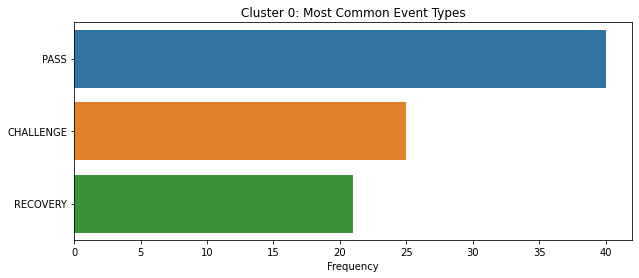

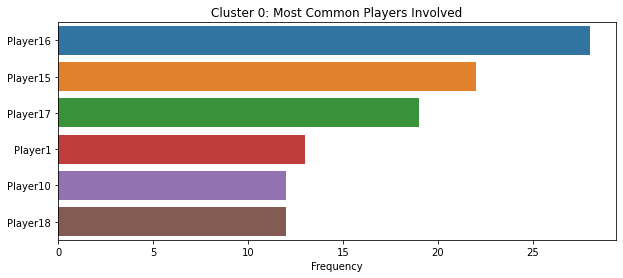

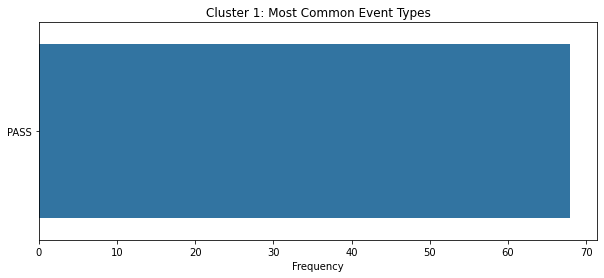

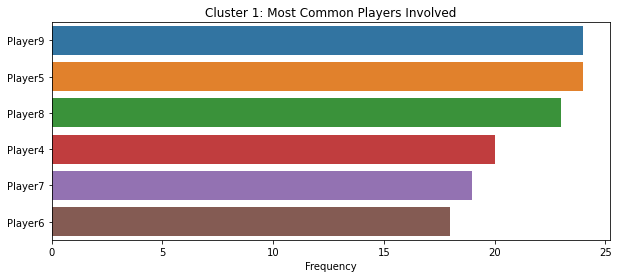

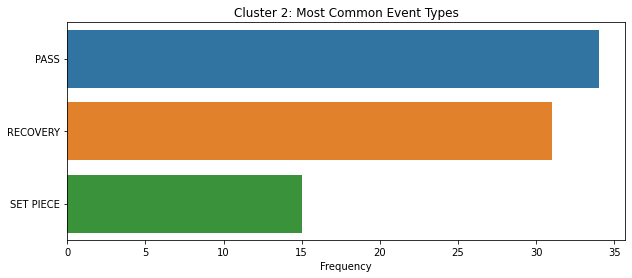

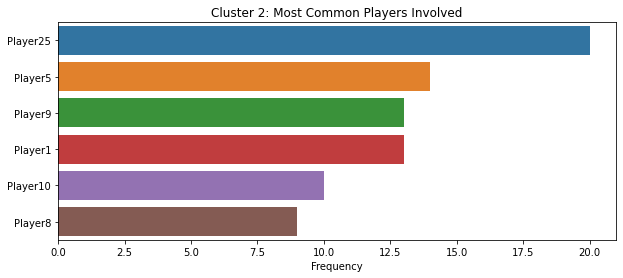

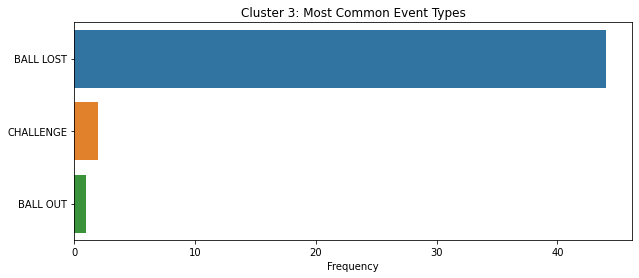

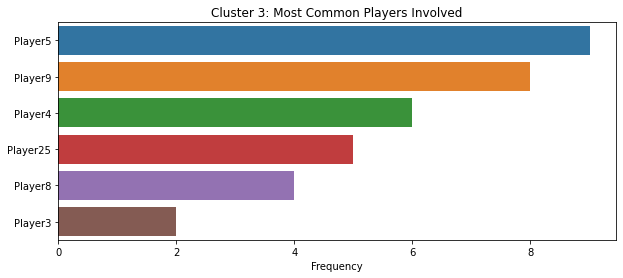

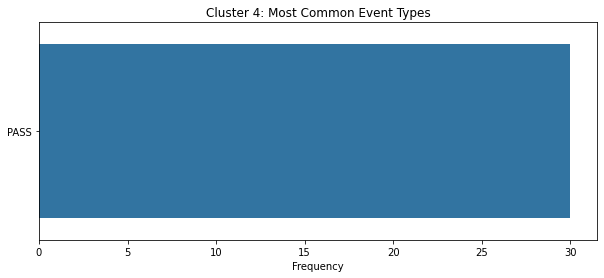

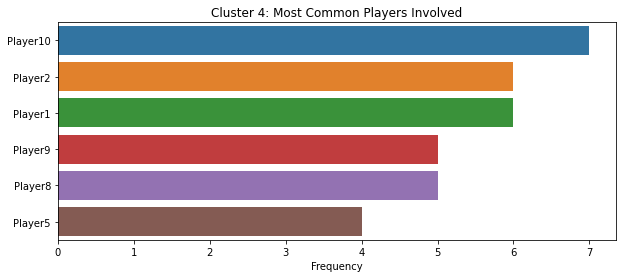

In [91]:

import seaborn as sns
def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = leading_events_away[leading_events_away['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

In [75]:
leading_events_home.drop(['Start Frame', 'End Frame', 'Start Time [s]', 'End Time [s]', 'Period', 'Start X', 'Start Y', 'End X', 'End Y'], axis=1, inplace=True)
leading_events_home

leading_events_home.to_csv('leading_events_home.csv')

# Creating the 'Type_s' column by combining 'Type' and 'Subtype'
leading_events_home['Type_s'] = leading_events_home.apply(lambda row: f"{row['Type']} - {row['Subtype']}" if pd.notna(row['Subtype']) else row['Type'], axis=1)

# Display the first few rows to confirm the new column
leading_events_home

,Team,Type,Subtype,From,To,Moment Period,Moment Time [s],Type_s
0,Away,BALL LOST,INTERCEPTION,Player24,NaN,1.0,55.96,BALL LOST - INTERCEPTION
1,Away,PASS,NaN,Player18,Player24,1.0,55.96,PASS
2,Away,PASS,NaN,Player20,Player18,1.0,55.96,PASS
3,Home,RECOVERY,INTERCEPTION,Player1,NaN,1.0,57.24,RECOVERY - INTERCEPTION
4,Away,BALL LOST,INTERCEPTION,Player24,NaN,1.0,57.24,BALL LOST - INTERCEPTION
...,...,...,...,...,...,...,...,...
322,Away,PASS,NaN,Player21,Player23,2.0,5437.80,PASS
323,Away,CHALLENGE,TACKLE-ADVANTAGE-WON,Player21,NaN,2.0,5437.80,CHALLENGE - TACKLE-ADVANTAGE-WON
324,Away,PASS,NaN,Player19,Player21,2.0,5437.80,PASS
325,Home,RECOVERY,NaN,Player11,NaN,2.0,5478.44,RECOVERY


In [76]:
# Grouping the data by 'Moment Time [s]' and creating triples of 'Type_s'
triples_home = leading_events_home.groupby('Moment Time [s]')['Type_s'].apply(lambda x: list(x)[:3])

# Convert the Series to a DataFrame for easier visualization
triples_home_df = pd.DataFrame(triples_home.tolist(), index=triples_home.index, columns=['Event 1', 'Event 2', 'Event 3'])

# Display the first few rows of the triples DataFrame
triples_home_df

,Event 1,Event 2,Event 3
Moment Time [s],,,
55.96,BALL LOST - INTERCEPTION,PASS,PASS
57.24,RECOVERY - INTERCEPTION,BALL LOST - INTERCEPTION,PASS
101.80,PASS,PASS,RECOVERY - INTERCEPTION
131.48,PASS,RECOVERY,BALL LOST
569.48,PASS,PASS,PASS
...,...,...,...
5387.04,PASS,PASS,PASS
5397.68,BALL LOST - INTERCEPTION,RECOVERY,RECOVERY - INTERCEPTION
5417.24,PASS,PASS,PASS


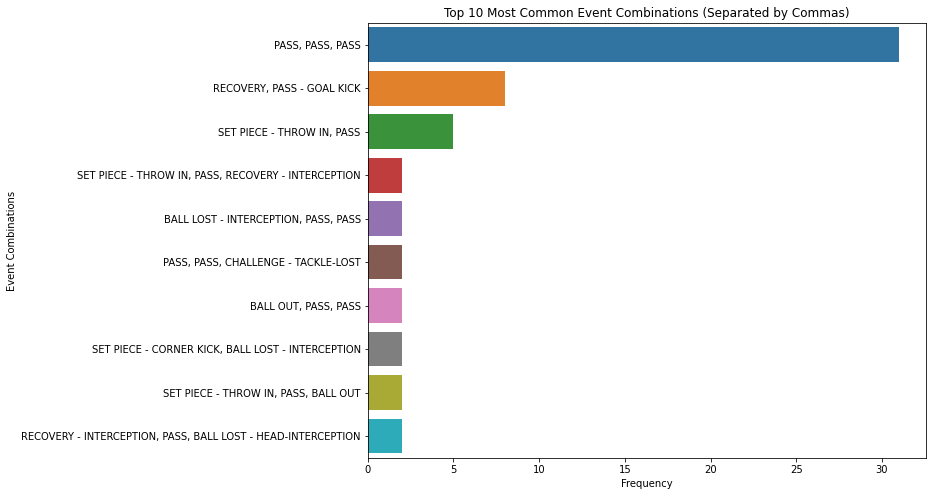

In [78]:
# Function to create pairs or singles from triples with ',' as a separator
def create_combinations(triple):
    # Filter out None values and join with ','
    filtered_events = [event for event in triple if event is not None]
    return ', '.join(filtered_events)

# Applying the function to create pairs or singles from triples with ',' as a separator
type_combinations = triples_home.apply(create_combinations)

# Counting the frequency of each adjusted triple (or pair/single) with ',' as a separator
type_combinations_count = type_combinations.value_counts()

# Creating a bar plot for the most common Leading Events for Home
plt.figure(figsize=(10, 8))
sns.barplot(y=type_combinations_count.index[:10], x=type_combinations_count.values[:10])  # Displaying top 10
plt.title('Top 10 Most Common Event Combinations (Separated by Commas)')
plt.xlabel('Frequency')
plt.ylabel('Event Combinations')
plt.show()

In [46]:
def create_event_triples(triple_leading_events):
    # Group by moment
    grouped = triple_leading_events.groupby(['Moment Period', 'Moment Time [s]'])

    # Create triples for each group
    triples = []
    for _, group in grouped:
        events = group.to_dict('records')
        triple = [events[i] if i < len(events) else None for i in range(3)]
        triples.append(triple)

    return pd.DataFrame(triples, columns=['Event 1', 'Event 2', 'Event 3'])

triples_away = create_event_triples(leading_events_away)

triples_away.head()


,Event 1,Event 2,Event 3
0,"{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'SET PIECE', 'Subtype...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."
1,"{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."
2,"{'Team': 'Home', 'Type': 'BALL LOST', 'Subtype...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na..."
3,"{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na..."
4,"{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na..."


In [47]:
triples_away.to_csv('triples_away.csv')

In [ ]:
triples_away

,Event 1,Event 2,Event 3
0,"{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'SET PIECE', 'Subtype...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."
1,"{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."
2,"{'Team': 'Home', 'Type': 'BALL LOST', 'Subtype...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na..."
3,"{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na..."
4,"{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na..."
...,...,...,...
113,"{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'SET PIECE', 'Subtype..."
114,"{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...",None
115,"{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Home', 'Type': 'PASS', 'Subtype': na..."
116,"{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na...","{'Team': 'Away', 'Type': 'PASS', 'Subtype': na..."


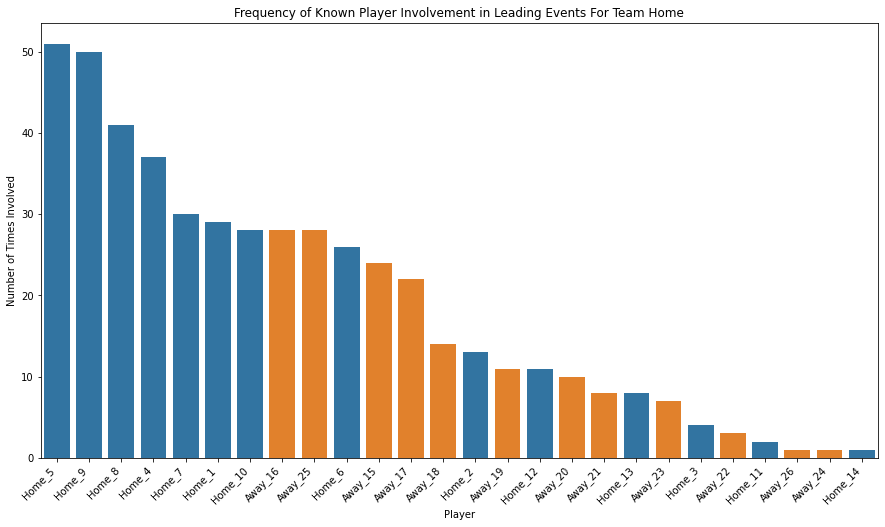

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_players = leading_events_away['From'].append(leading_events_away['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

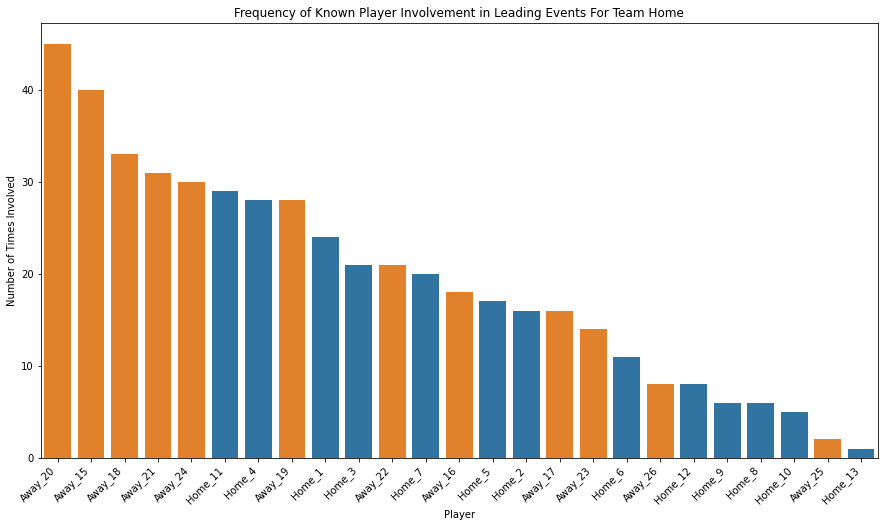

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

combined_players = leading_events_home['From'].append(leading_events_home['To'])
player_counts = combined_players.value_counts()

# Creating a DataFrame for player counts
player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()
player_counts_df.columns = ['Player', 'Count']

# Function to label players with their team
def label_player_with_team(player):
    if player.startswith('Player'):
        player_number = int(player.replace('Player', ''))
        if 1 <= player_number <= 14:
            return 'Home_' + str(player_number)
        elif 15 <= player_number <= 26:
            return 'Away_' + str(player_number)
    return player

# Apply the function to label players with their team
player_counts_df['Player'] = player_counts_df['Player'].apply(label_player_with_team)

# Excluding 'Unknown' from the player counts
player_counts_df = player_counts_df[player_counts_df['Player'] != 'Unknown']

# Sorting the DataFrame by player counts
player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

# Assigning colors based on the team
colors = ['#1f77b4' if 'Home' in player else '#ff7f0e' for player in player_counts_df_sorted['Player']]

# Plotting the histogram
plt.figure(figsize=(15, 8))
sns.barplot(x='Player', y='Count', data=player_counts_df_sorted, palette=colors)
plt.xticks(rotation=45, ha='right')
plt.title('Frequency of Known Player Involvement in Leading Events For Team Home')
plt.xlabel('Player')
plt.ylabel('Number of Times Involved')
plt.show()

In [ ]:
leading_events_home.to_csv("leading_events_home.csv")

In [ ]:
leading_events_away.to_csv("leading_events_away.csv")

Grid the Pitch

In [94]:

away_moments_down = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2) & (tracking_data['ball_y'] <= -11.33)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1) & (tracking_data['ball_y'] <= -11.33))]
away_moments_down.columns
away_moments_center = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2) & (tracking_data['ball_y'] < 11.33) & (tracking_data['ball_y'] > -11.33)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1) & (tracking_data['ball_y'] < 11.33) & (tracking_data['ball_y'] > -11.33))]
away_moments_center.columns
away_moments_up = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 2) & (tracking_data['ball_y'] >= 11.33)) | ((tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 1) & (tracking_data['ball_y'] >= 11.33))]
away_moments_up.columns


leading_events_away_down = find_leading_events(away_moments_down, events, time_window)
leading_events_away_down.head()

leading_events_away_center = find_leading_events(away_moments_center, events, time_window)
leading_events_away_center.head()

leading_events_away_up = find_leading_events(away_moments_up, events, time_window)
leading_events_away_up.head()

triples_away_down = create_event_triples(leading_events_away_down)
triples_away_center = create_event_triples(leading_events_away_center)
triples_away_up = create_event_triples(leading_events_away_up)

# Create event type triples for home and away
type_triples_away_down = create_event_type_triples(leading_events_away_down)
type_triples_away_center = create_event_type_triples(leading_events_away_center)
type_triples_away_up = create_event_type_triples(leading_events_away_up)

<AxesSubplot:>

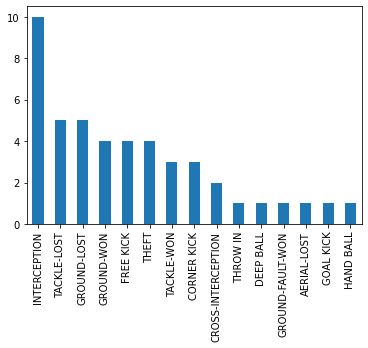

In [119]:
leading_events_away_down['Subtype'].value_counts().plot(kind='bar')

<AxesSubplot:>

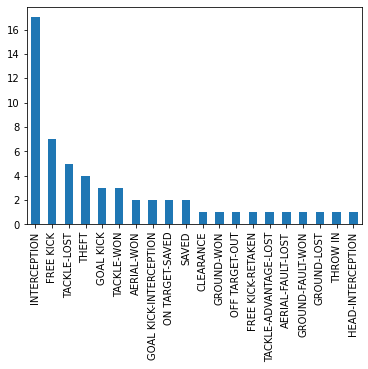

In [118]:
leading_events_away_center['Subtype'].value_counts().plot(kind='bar')

<AxesSubplot:>

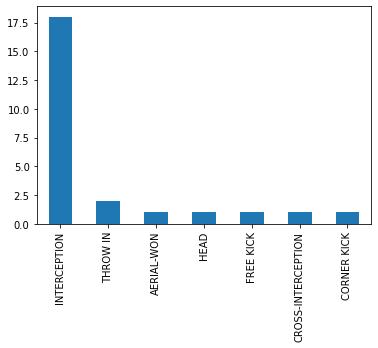

In [120]:
leading_events_away_up['Subtype'].value_counts().plot(kind='bar')

In [104]:

import seaborn as sns

plt.figure(figsize=(10, 4))

sns.barplot(x=type_triples_away_down.values, y=type_triples_away_down.index)

plt.title("zszcs")

plt.xlabel('Frequency')

plt.ylabel('')

plt.show()

TypeError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 720x288 with 0 Axes>

In [98]:
# Function to create pairs or singles from triples with ',' as a separator
def create_combinations(triple):
    # Filter out None values and join with ','
    filtered_events = [event for event in triple if event is not None]
    return (filtered_events)

# Applying the function to create pairs or singles from triples with ',' as a separator
type_triples_away_down = type_triples_away_down.apply(create_combinations)



# Counting the frequency of each adjusted triple (or pair/single) with ',' as a separator
type_triples_away_down_count = type_triples_away_down.value_counts()

# Creating a bar plot for the most common Leading Events for Home
plt.figure(figsize=(10, 8))
sns.barplot(y=type_triples_away_down_count.index[:10], x=type_triples_away_down_count.values[:10])  # Displaying top 10
plt.title('Top 10 Most Common Event Combinations (Separated by Commas)')
plt.xlabel('Frequency')
plt.ylabel('Events')
plt.show()

TypeError: data type 'object' not understood

In [96]:
type_triples_away_up

,1 Event Before,2 Events Before,3 Events Before
0,BALL LOST,PASS,PASS
1,PASS,PASS,PASS
2,PASS,PASS,PASS
3,PASS,PASS,SET PIECE
4,BALL LOST,PASS,PASS
5,PASS,PASS,PASS
6,BALL LOST,PASS,PASS
7,RECOVERY,BALL LOST,BALL LOST
8,RECOVERY,RECOVERY,BALL LOST
9,PASS,PASS,PASS


#### SEPRATING PERIODS For Home

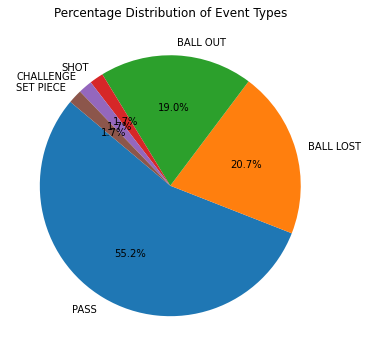

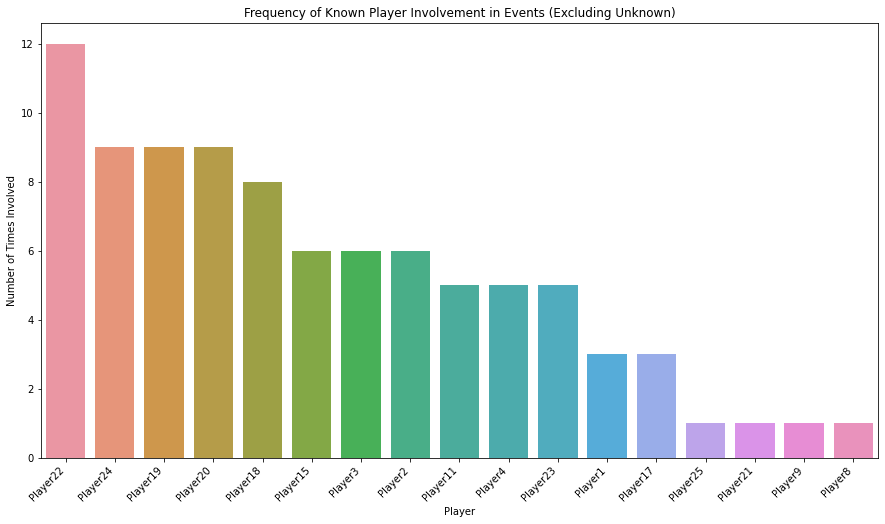

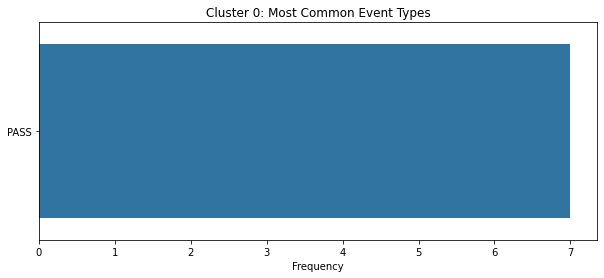

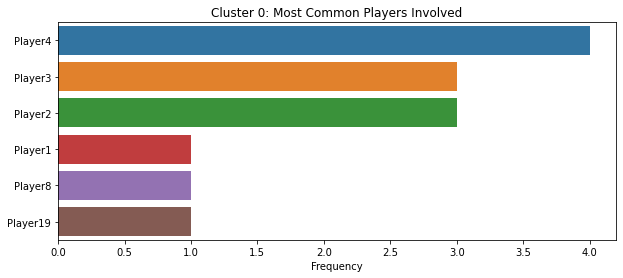

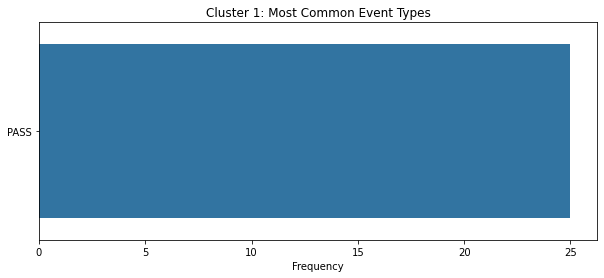

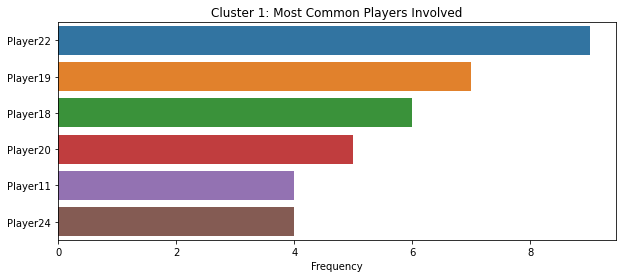

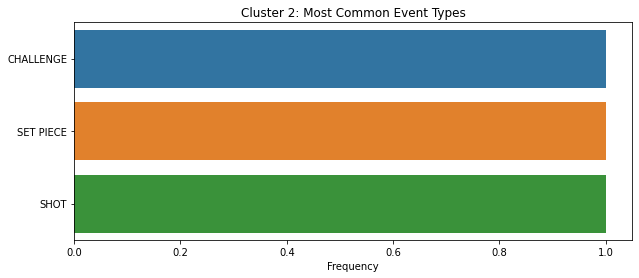

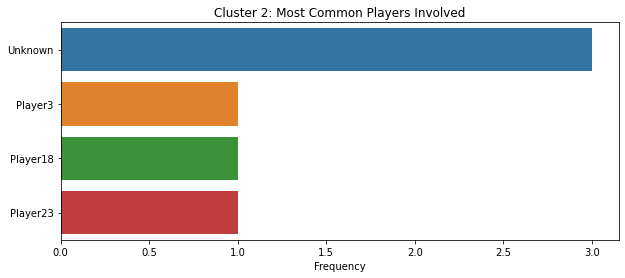

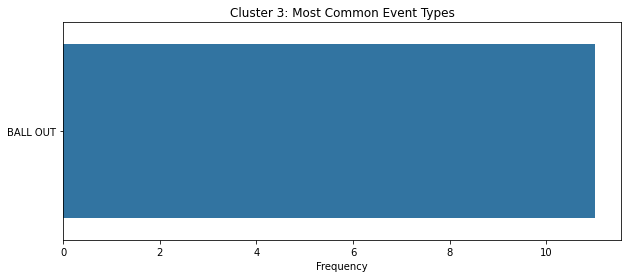

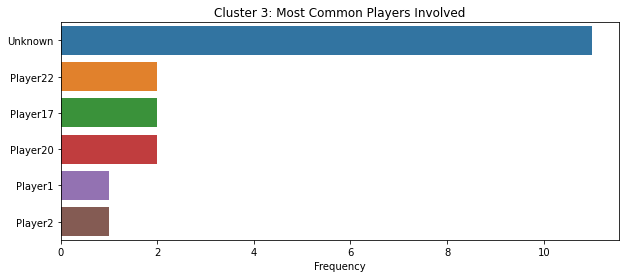

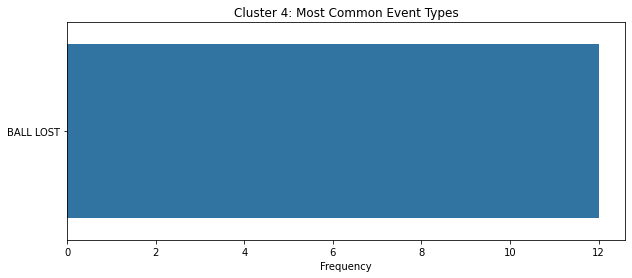

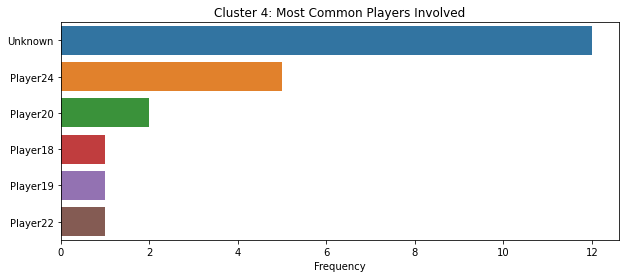

In [ ]:

home_moments = tracking_data[((tracking_data['ball_x'] > 26.25) & (tracking_data['ball_x'].shift(1) <= 26.25) & (tracking_data['Period'] == 1))]

home_moments.columns


import numpy as np
a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

for index, row in home_moments.iterrows():

    distances_away = []

    distances_home = []

    ball_x = row['ball_x']

    ball_y = row['ball_y']

  

    for a_player in a_players:

    # Get the index of the current player column

        a_index = row.index.get_loc(a_player)

        away_x = row.iloc[a_index]

        away_y = row.iloc[a_index + 1]

  

        # Calculate Euclidean distance

        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)

        distances_away.append(distance_away)

  

    for h_player in h_players:

        # Get the index of the current player column

        h_index = row.index.get_loc(h_player)

        home_x = row.iloc[h_index]

        home_y = row.iloc[h_index + 1]


        # Calculate Euclidean distance

        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)

        distances_home.append(distance_home)

    away_min_dist = np.min(distances_away)

    home_min_dist = np.min(distance_home)

    # Find the minimum distance for the current row

    if home_min_dist < away_min_dist :

        home_moments.drop(index, inplace=True)


home_event = pd.DataFrame(columns=events.columns)

  

for index, row in home_moments.iterrows():

    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row

        if e_index > 0:

            current_start_time = e_row['Start Time [s]']

            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']

            home_time = row['Time [s]']

  

            # Check both the current and previous start times against home_time

            if current_start_time >= home_time and previous_start_time < home_time:

                 home_event = home_event.append(events.iloc[e_index - 1], ignore_index=True)



event_type_counts = home_event['Type'].value_counts()


plt.figure(figsize=(10, 6))

plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage Distribution of Event Types')

plt.show()


home_event['Subtype'].fillna('Unknown', inplace=True)

home_event['To'].fillna('Unknown', inplace=True)

imputation_check = home_event[['Subtype', 'To']].isnull().sum()

imputation_check


import seaborn as sns

  

combined_players = home_event['From'].append(home_event['To'])

player_counts = combined_players.value_counts()

  

# Creating a DataFrame for player counts

player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()

player_counts_df.columns = ['Player', 'Count']

player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

player_counts_excluding_unknown = player_counts.drop('Unknown')


player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()

player_counts_df.columns = ['Player', 'Count']


player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)


plt.figure(figsize=(15, 8))

sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)

plt.xticks(rotation=45, ha='right')

plt.title('Frequency of Known Player Involvement in Events (Excluding Unknown)')

plt.xlabel('Player')

plt.ylabel('Number of Times Involved')

plt.show()

from sklearn.preprocessing import OneHotEncoder

  
features = home_event[['Type', 'Subtype', 'From', 'To']]


encoder = OneHotEncoder(sparse=False)

encoded_features = encoder.fit_transform(features)


encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

  

encoded_df.head()



kmeans = KMeans(n_clusters=5, random_state=42)

clusters = kmeans.fit_predict(encoded_df)

home_event['Cluster'] = clusters

home_event.head()


cluster_analysis = []

for cluster_num in range(5):

    cluster_data = home_event[home_event['Cluster'] == cluster_num]

    # Most common event types in this cluster

    common_types = cluster_data['Type'].value_counts().head(3)

    # Most common 'From' players in this cluster

    common_from_players = cluster_data['From'].value_counts().head(3)

    # Most common 'To' players in this cluster

    common_to_players = cluster_data['To'].value_counts().head(3)

  

    cluster_analysis.append({

        'Cluster': cluster_num,

        'Most Common Event Types': common_types,

        'Most Common From Players': common_from_players,

        'Most Common To Players': common_to_players

    })


cluster_analysis_df = pd.DataFrame(cluster_analysis)

cluster_analysis_df.set_index('Cluster', inplace=True)

cluster_analysis_df

import seaborn as sns

  

def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = home_event[home_event['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

c:\Users\USER\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


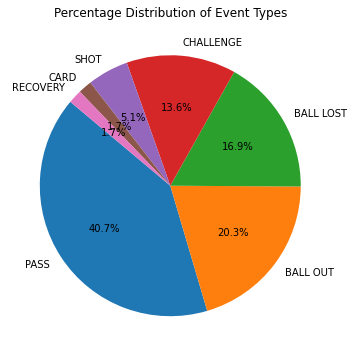

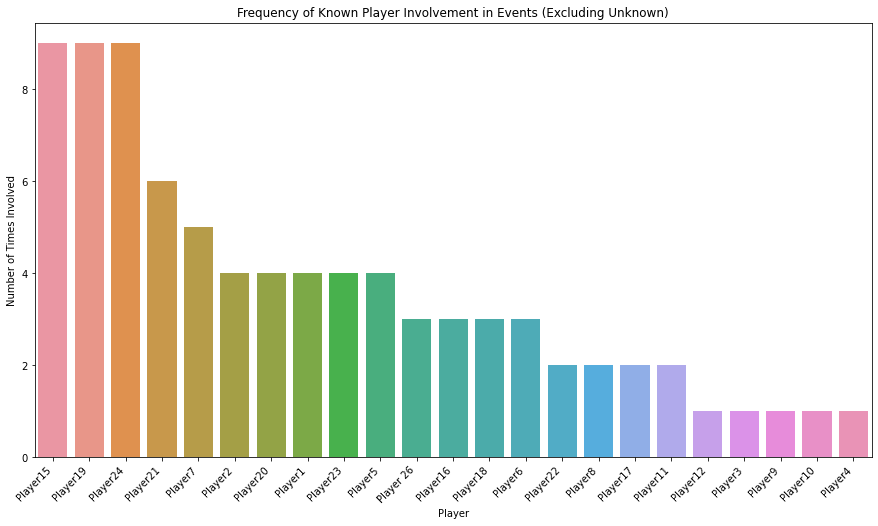

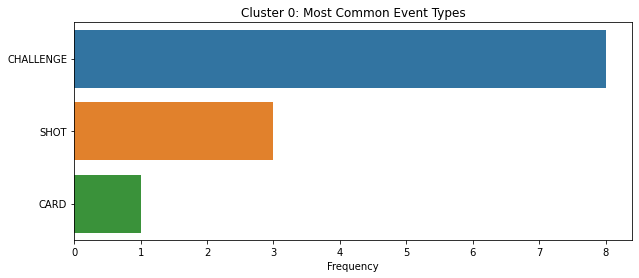

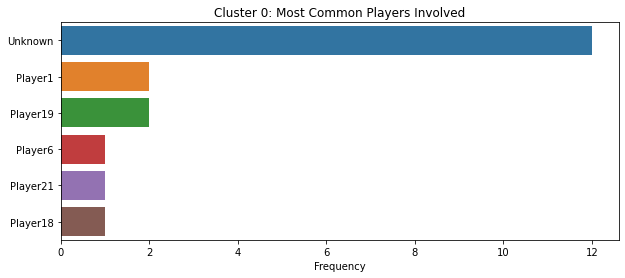

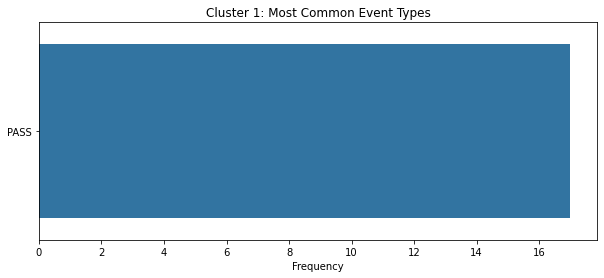

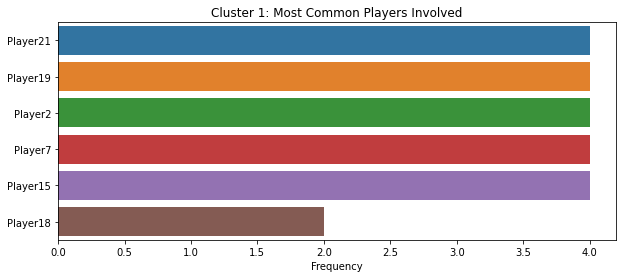

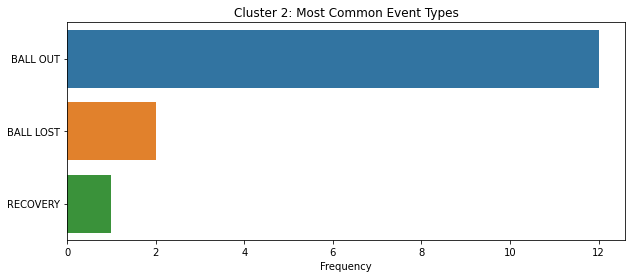

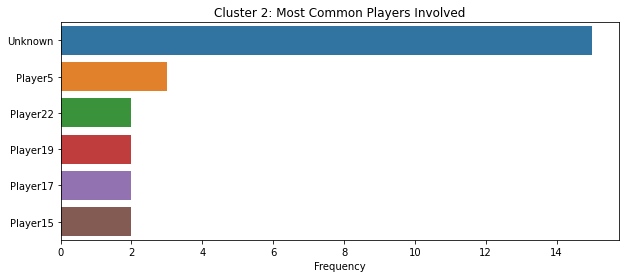

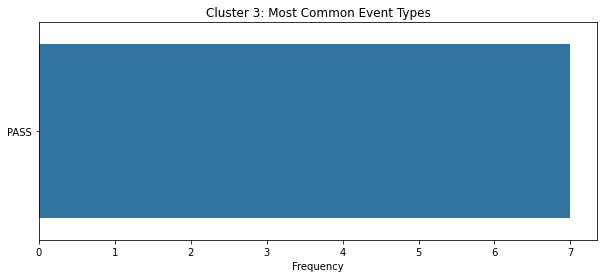

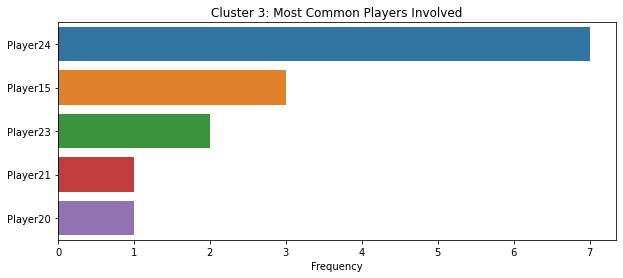

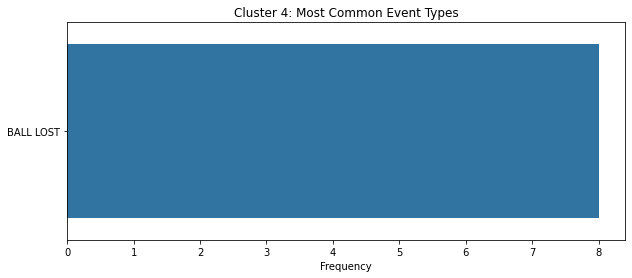

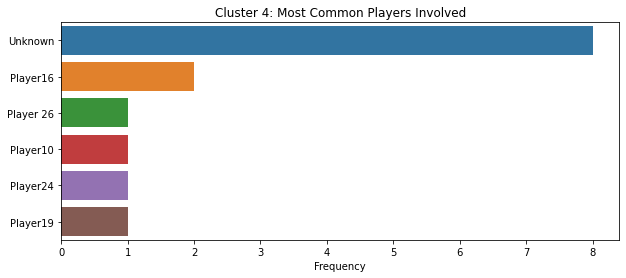

In [ ]:

home_moments = tracking_data[(tracking_data['ball_x'] < -26.25) & (tracking_data['ball_x'].shift(1) >= -26.25) & (tracking_data['Period'] == 2)]
home_moments.columns

import numpy as np
a_players = home_moments.columns[2:24:2]
h_players = home_moments.columns[26:52:2]
ball_columns = ['ball_x', 'ball_y']

min_distances = []
counter = 0

for index, row in home_moments.iterrows():

    distances_away = []

    distances_home = []

    ball_x = row['ball_x']

    ball_y = row['ball_y']

  

    for a_player in a_players:

    # Get the index of the current player column

        a_index = row.index.get_loc(a_player)

        away_x = row.iloc[a_index]

        away_y = row.iloc[a_index + 1]

  

        # Calculate Euclidean distance

        distance_away = np.sqrt((away_x - ball_x)**2 + (away_y - ball_y)**2)

        distances_away.append(distance_away)

  

    for h_player in h_players:

        # Get the index of the current player column

        h_index = row.index.get_loc(h_player)

        home_x = row.iloc[h_index]

        home_y = row.iloc[h_index + 1]


        # Calculate Euclidean distance

        distance_home = np.sqrt((home_x - ball_x)**2 + (home_y - ball_y)**2)

        distances_home.append(distance_home)

    away_min_dist = np.min(distances_away)

    home_min_dist = np.min(distance_home)

    # Find the minimum distance for the current row

    if home_min_dist < away_min_dist :

        home_moments.drop(index, inplace=True)


home_event = pd.DataFrame(columns=events.columns)

  

for index, row in home_moments.iterrows():

    for e_index, e_row in events.iterrows():

        # Check if it's not the first row to avoid IndexError for previous row

        if e_index > 0:

            current_start_time = e_row['Start Time [s]']

            previous_start_time = events.iloc[e_index - 1]['Start Time [s]']

            home_time = row['Time [s]']

  

            # Check both the current and previous start times against home_time

            if current_start_time >= home_time and previous_start_time < home_time:

                 home_event = home_event.append(events.iloc[e_index - 1], ignore_index=True)



event_type_counts = home_event['Type'].value_counts()


plt.figure(figsize=(10, 6))

plt.pie(event_type_counts, labels = event_type_counts.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage Distribution of Event Types')

plt.show()


home_event['Subtype'].fillna('Unknown', inplace=True)

home_event['To'].fillna('Unknown', inplace=True)

imputation_check = home_event[['Subtype', 'To']].isnull().sum()

imputation_check


import seaborn as sns

  

combined_players = home_event['From'].append(home_event['To'])

player_counts = combined_players.value_counts()

  

# Creating a DataFrame for player counts

player_counts_df = pd.DataFrame.from_dict(player_counts).reset_index()

player_counts_df.columns = ['Player', 'Count']

player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)

player_counts_excluding_unknown = player_counts.drop('Unknown')


player_counts_df = pd.DataFrame.from_dict(player_counts_excluding_unknown).reset_index()

player_counts_df.columns = ['Player', 'Count']


player_counts_df_sorted = player_counts_df.sort_values(by='Count', ascending=False)


plt.figure(figsize=(15, 8))

sns.barplot(x='Player', y='Count', data=player_counts_df_sorted)

plt.xticks(rotation=45, ha='right')

plt.title('Frequency of Known Player Involvement in Events (Excluding Unknown)')

plt.xlabel('Player')

plt.ylabel('Number of Times Involved')

plt.show()

from sklearn.preprocessing import OneHotEncoder

  
features = home_event[['Type', 'Subtype', 'From', 'To']]


encoder = OneHotEncoder(sparse=False)

encoded_features = encoder.fit_transform(features)


encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(features.columns))

  

encoded_df.head()



kmeans = KMeans(n_clusters=5, random_state=42)

clusters = kmeans.fit_predict(encoded_df)

home_event['Cluster'] = clusters

home_event.head()


cluster_analysis = []

for cluster_num in range(5):

    cluster_data = home_event[home_event['Cluster'] == cluster_num]

    # Most common event types in this cluster

    common_types = cluster_data['Type'].value_counts().head(3)

    # Most common 'From' players in this cluster

    common_from_players = cluster_data['From'].value_counts().head(3)

    # Most common 'To' players in this cluster

    common_to_players = cluster_data['To'].value_counts().head(3)

  

    cluster_analysis.append({

        'Cluster': cluster_num,

        'Most Common Event Types': common_types,

        'Most Common From Players': common_from_players,

        'Most Common To Players': common_to_players

    })


cluster_analysis_df = pd.DataFrame(cluster_analysis)

cluster_analysis_df.set_index('Cluster', inplace=True)

cluster_analysis_df

import seaborn as sns

  

def plot_cluster_data(cluster_num, cluster_data, title):

    """
    Plot the data for a given cluster.
    """

    plt.figure(figsize=(10, 4))

    sns.barplot(x=cluster_data.values, y=cluster_data.index)

    plt.title(f"Cluster {cluster_num}: {title}")

    plt.xlabel('Frequency')

    plt.ylabel('')

    plt.show()


for cluster_num in range(5):

    cluster = home_event[home_event['Cluster'] == cluster_num]

  

# Most common event types

    common_types = cluster['Type'].value_counts().head(3)

    plot_cluster_data(cluster_num, common_types, 'Most Common Event Types')



    # Combining 'From' and 'To' players for a comprehensive view

    combined_players = cluster['From'].append(cluster['To']).value_counts().head(6)

    plot_cluster_data(cluster_num, combined_players, 'Most Common Players Involved')

In [ ]:
events

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,51,2.04,51,2.04,Player23,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,51,2.04,87,3.48,Player23,Player20,0.50,0.50,0.40,0.51
2,Away,PASS,NaN,1,146,5.84,186,7.44,Player20,Player18,0.43,0.50,0.44,0.22
3,Away,PASS,NaN,1,248,9.92,283,11.32,Player18,Player17,0.47,0.19,0.31,0.28
4,Away,PASS,NaN,1,316,12.64,346,13.84,Player17,Player16,0.29,0.32,0.26,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,Away,BALL LOST,INTERCEPTION,2,140122,5604.88,140183,5607.32,Player21,NaN,0.54,0.77,0.29,0.24
1931,Home,CHALLENGE,AERIAL-LOST,2,140180,5607.20,140180,5607.20,Player1,NaN,0.31,0.30,NaN,NaN
1932,Away,CHALLENGE,AERIAL-LOST,2,140183,5607.32,140183,5607.32,Player24,NaN,0.32,0.30,NaN,NaN
1933,Home,RECOVERY,NaN,2,140211,5608.44,140211,5608.44,Player12,NaN,0.34,0.32,NaN,NaN


In [ ]:
events['Subtype'].unique()

array(['KICK OFF', nan, 'INTERCEPTION', 'GROUND-LOST', 'GROUND-WON',
       'THROW IN', 'AERIAL-WON', 'HEAD-INTERCEPTION', 'AERIAL-LOST',
       'HEAD', 'OFF TARGET-OUT', 'TACKLE-LOST', 'AERIAL-FAULT-WON',
       'AERIAL-FAULT-LOST', 'FREE KICK', 'TACKLE-WON', 'CORNER KICK',
       'THEFT', 'CROSS', 'ON TARGET-GOAL', 'ON TARGET-SAVED', 'SAVED',
       'BLOCKED', 'DEEP BALL', 'GROUND-FAULT-LOST', 'GROUND-FAULT-WON',
       'GROUND-ADVANTAGE-LOST', 'GROUND-ADVANTAGE-WON',
       'HEAD-OFF TARGET-OUT', 'GOAL KICK-INTERCEPTION',
       'TACKLE-FAULT-LOST', 'OFFSIDE', 'TACKLE-FAULT-WON', 'YELLOW',
       'CLEARANCE', 'GOAL KICK', 'TACKLE-ADVANTAGE-WON',
       'CROSS-INTERCEPTION', 'GROUND', 'FORCED', 'FAULT-WON',
       'OFF TARGET-HEAD-OUT', 'FORCED-END HALF', 'KICK OFF-RETAKEN',
       'HEAD-ON TARGET-GOAL', 'HEAD-INTERCEPTION-CLEARANCE',
       'TACKLE-ADVANTAGE-LOST', 'HEAD-CLEARANCE', 'FREE KICK-RETAKEN',
       'HAND BALL', 'PENALTY', 'DRIBBLE-WON', 'CLEARANCE-INTERCEPTION'],
      d

In [ ]:
events['Type'].unique()


array(['SET PIECE', 'PASS', 'BALL LOST', 'CHALLENGE', 'RECOVERY',
       'BALL OUT', 'SHOT', 'FAULT RECEIVED', 'CARD'], dtype=object)